# Machine learning project on customer segmentation  
<h3> Group members: Carucci Matteo, Agudio Tommaso, Natoli Vittorio Alessandro </h3>

<p style="font-size: 16px" font-family="sans-serif">
In the first part of the project, we deal with a customers database where customers' orders in Brazil are registered. There are many information stored for each order, including the price spent and also some relevant information about the customer and sellers themselves; Below we will start an explorative data analysis to find out more of the "customer_segmentation" dataset to capture some interesting trends and patterns.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import scipy.cluster.hierarchy as sch
#import altair as alt 
%matplotlib inline

df = pd.read_csv('customer_segmentation.csv')
df.drop_duplicates(inplace = True)
df.columns





Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_city', 'seller_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_category_name_english'],
      dtype='object')

## Data preparation

In [3]:
df.shape
df['customer_unique_id'].nunique()    #we will drop this column as it sis not useful for our analysis
df['customer_id'].nunique()
df.drop(columns = 'customer_unique_id',inplace= True)

<p style="font-size: 16px" font-family="sans-serif">
After checking all the features and dropped the unnecessary column "customer_unique_id", which will not help us identify the customers, as it is unique and we want to group by and find out customers behaviour, customer_id is more useful, as it is repeated in the case a customer has placed more than one order. We would like to do 2 important things; first, take a look at the dataset head itself and then see how many and what the categorical variables are, in order to encode them.

In [4]:
df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,...,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,belo horizonte,SP,perfumaria,29,178,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,credit_card,5,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,belo horizonte,SP,perfumaria,29,178,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,belo horizonte,SP,perfumaria,29,178,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery


In [5]:
df['payment_value']

0        141.46
1        135.82
2        128.04
3        279.30
4        279.30
          ...  
13796     27.39
13797     26.38
13798     26.38
13799     52.57
13800    804.96
Name: payment_value, Length: 13718, dtype: float64

<p style="font-size: 16px" font-family="sans-serif">
Now we want to see which columns contain categorical values, so that we will be able to use OneHotEncoder/get_dummies on those columns to start with our analysis. We can either use the info method or select the specific datatype we want to display (categorical).

In [5]:
#Checking the features that are categorical

categorical_features = df.select_dtypes(include='O').keys()

#Displaying those features

categorical_features

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_type', 'customer_city', 'customer_state', 'product_id',
       'seller_id', 'shipping_limit_date', 'seller_city', 'seller_state',
       'product_category_name', 'product_category_name_english'],
      dtype='object')

<p style="font-size: 16px" font-family="sans-serif">
As we want to get a dataset which is as essential as possible, we find some features that are not of any particular interest for both data exploration and analysis. These will be:
<ul> 
<li>  'product_name_lenght' </li>
<li>  'product_description_lenght' </li>
<li> 'shipping_limit_date' </li>
<li>  'product_category_name', which is a duplicate and it is in brazilian </li>






In [6]:
cat =  ['product_name_lenght','product_description_lenght','shipping_limit_date','product_category_name']
df.drop(columns = cat , axis = 1, inplace= True) 

<p style="font-size: 16px" font-family="sans-serif">
We want to use OneHotEncoder only on the unique features, because otherwise we would get a non-sense giant dataset with thousands of columns.

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(sparse= False), ['order_status','payment_type', 'customer_city', 'customer_state', 'seller_city','seller_state', 'product_category_name_english']),
    remainder='passthrough')

encoded_df = transformer.fit_transform(df)
encoded_df = pd.DataFrame(
    encoded_df, 
    columns=transformer.get_feature_names_out()  #getting the feature_names to get it better
)

encoded_df.head()




,onehotencoder__order_status_canceled,onehotencoder__order_status_delivered,onehotencoder__order_status_invoiced,onehotencoder__order_status_processing,onehotencoder__order_status_shipped,onehotencoder__payment_type_boleto,onehotencoder__payment_type_credit_card,onehotencoder__payment_type_debit_card,onehotencoder__payment_type_voucher,onehotencoder__customer_city_abaete,...,remainder__order_delivered_carrier_date,remainder__order_delivered_customer_date,remainder__order_estimated_delivery_date,remainder__payment_installments,remainder__payment_value,remainder__order_item_id,remainder__product_id,remainder__seller_id,remainder__price,remainder__freight_value
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,141.46,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.7,22.76
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,5,135.82,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,116.9,18.92
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,1,128.04,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.7,9.34
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,2,279.3,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,116.9,22.75
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,2,279.3,2,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,116.9,22.75


<p style="font-size: 16px" font-family="sans-serif">
As one can see, it is not particularly convenient to produce so many columns; get_dummies might be an alternative.

In [8]:
dummies_df = pd.get_dummies(df, columns = ['order_status','payment_type', 'customer_city', 'customer_state', 'seller_city','seller_state', 'product_category_name_english'])

dummies_df.head()



,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_installments,payment_value,order_item_id,...,product_category_name_english_pet_shop,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,141.46,1,...,0,0,0,0,0,0,0,0,0,0
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,5,135.82,1,...,0,0,0,0,0,0,0,0,0,0
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,1,128.04,1,...,0,0,0,0,0,0,0,0,0,0
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,2,279.30,1,...,0,0,0,0,0,0,0,0,0,0
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,2,279.30,2,...,0,0,0,0,0,0,0,0,0,0


## RFM analysis, the importance of customer recency, frequency and monetary value.

<p style="font-size: 16px" font-family="sans-serif">
Before starting analyzing the dataset, we want to introduce and start working on the real goal of the project; segmenting customers using clusters which identify similarities in consumer behaviour, based on the dataset information.
The RFM analysis will help us accomplish so: RFM stands for Frequency (The frequency of purchases of a customer), Recency (How long has been since the last purchase of a customer) and Monetary (How much a customer has spent over its time using the marketplace). We will firstly calculate the frequency and generate a new dataset containing 2 columns (CustomerName and Frequency) and going on creating one dataframe for each feature and then concatenate them all. Note that we will use the original dataframe because we don't need any of the categorical features in order to calculate the RFM values. To retrieve these 3 features we will use simple groupby.
    

In [9]:
#dropping order which have not been delivered is important. Instead of dropping, we consider df as the dataframe having only
#orders delivered
df = df[df['order_status'] == 'delivered']
df.head()
df.shape

(13414, 21)

Then we get the frequency, that is, the number of orders made by the customers, a group by and a count allows us to get these.

In [10]:

frequencies = df.groupby(
    by=['customer_id'], as_index=False)['order_delivered_customer_date'].count()
frequencies.columns = ['Frequencies Customer ID', 'Frequency']
frequencies.head()

,Frequencies Customer ID,Frequency
0,001051abfcfdbed9f87b4266213a5df1,3
1,0013cd8e350a7cc76873441e431dd5ee,1
2,0015bc9fd2d5395446143e8b215d7c75,1
3,0018c09f333634ca9c80d9ff46e43e9c,1
4,001df1ee5c36767aa607001ab1a13a06,1


<i style ="font-size: 15px"> 
 Frequencies df contains the purchase frequency for each customer.

We now do the same, we though sum the payment values made by each customer_id(unique customer).

In [11]:
#grouping by and getting the total money spent by customer
monetary = df.groupby(by='customer_id', as_index=False)['payment_value'].sum()
monetary.columns = [' Monetary Customer ID', 'Monetary value']
monetary.head()

,Monetary Customer ID,Monetary value
0,001051abfcfdbed9f87b4266213a5df1,65.20
1,0013cd8e350a7cc76873441e431dd5ee,92.60
2,0015bc9fd2d5395446143e8b215d7c75,132.19
3,0018c09f333634ca9c80d9ff46e43e9c,56.87
4,001df1ee5c36767aa607001ab1a13a06,42.86


<i style ="font-size: 15px"> Total money spent by customer.


Creating the recency dataset (note that the INT value containted in the 'recency' column shows the number of days since the last purchase of a user)

In [12]:
#using order_purchase_timestamp instead of delivered_carrier_date.
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

recency = df.groupby(by='customer_id',
                        as_index=False)['order_purchase_timestamp'].max()

recency.columns = ['Customer ID', 'Latest Purchase']

recent_date = recency['Latest Purchase'].max()

recency['Recency'] = recency['Latest Purchase'].apply(
    lambda x: (recent_date - x).days)                     
    
recency.head()


,Customer ID,Latest Purchase,Recency
0,001051abfcfdbed9f87b4266213a5df1,2018-05-30 09:19:31,91
1,0013cd8e350a7cc76873441e431dd5ee,2018-05-07 23:25:09,113
2,0015bc9fd2d5395446143e8b215d7c75,2018-06-11 19:48:34,78
3,0018c09f333634ca9c80d9ff46e43e9c,2018-07-01 18:07:57,58
4,001df1ee5c36767aa607001ab1a13a06,2018-08-05 23:14:45,23


<p style="font-size: 16px" font-family="sans-serif">
After that we have created the three different dataframes, we want to concatenate them in order to have a single and clean  dataframe. After many trials we decided not to scale data with either MinMax or Linear scaling(Standard) since it would compromise the values of the frequency, with many equal to 0; moreover neither the clusters distance nor the silhouette score improve significantly.

In [13]:
rfm_dataset = None 
rfm_dataset = pd.DataFrame(rfm_dataset)

rfm_dataset = pd.concat([recency,monetary,frequencies], axis = 1)

cols = [3,5]    #useless columns

rfm_dataset = rfm_dataset.drop(rfm_dataset.columns[cols],axis = 1)

rfm_dataset.drop(columns =['Latest Purchase'], axis = 1, inplace = True)  #we don't care about the date (we have recency)

rfm_dataset.dropna(inplace = True)   #dropping the nulls, if any
    
#scaling the data
'''from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = MinMaxScaler()
sc_features = rfm_dataset.copy() 



new = sc.fit_transform(sc_features['Monetary value'].array.reshape(-1,1))
new2 = sc.fit_transform(sc_features['Recency'].array.reshape(-1,1))
new3 = sc.fit_transform(sc_features['Frequency'].array.reshape(-1,1))
sc_features['Monetary value'] = new
sc_features['Recency'] = new2 
sc_features['Frequency'] = new3 '''



#sc_features = sc_features.dropna()
#sc_features.head()

"from sklearn.preprocessing import StandardScaler, MinMaxScaler\nsc = MinMaxScaler()\nsc_features = rfm_dataset.copy() \n\n\n\nnew = sc.fit_transform(sc_features['Monetary value'].array.reshape(-1,1))\nnew2 = sc.fit_transform(sc_features['Recency'].array.reshape(-1,1))\nnew3 = sc.fit_transform(sc_features['Frequency'].array.reshape(-1,1))\nsc_features['Monetary value'] = new\nsc_features['Recency'] = new2 \nsc_features['Frequency'] = new3 "

<p style="font-size: 16px" font-family="sans-serif"> Visualzing the final rfm dataframe:

In [14]:
rfm_dataset.head()

,Customer ID,Recency,Monetary value,Frequency
0,001051abfcfdbed9f87b4266213a5df1,91,65.20,3
1,0013cd8e350a7cc76873441e431dd5ee,113,92.60,1
2,0015bc9fd2d5395446143e8b215d7c75,78,132.19,1
3,0018c09f333634ca9c80d9ff46e43e9c,58,56.87,1
4,001df1ee5c36767aa607001ab1a13a06,23,42.86,1


<i style ="font-size: 15px">   The final rfm dataframe head.

## Exploratory data analysis, a brief look into the RFM dataframe.



### Pairplot

<p style="font-size: 16px" font-family="sans-serif">To see and understand better the dataset, we now pairplot and see if there exists correlation between the different RFM features.

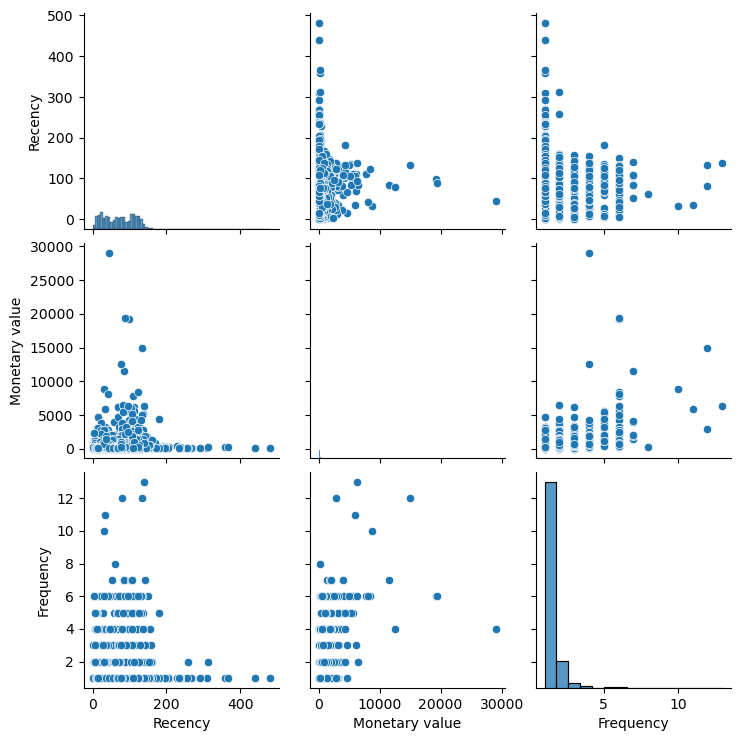

In [16]:
#pairplot in new RFm dataset
sns.pairplot(rfm_dataset)

<i style ="font-size: 15px">  As one can easily notice from the pairplot above there's a clear trend: customers who have purchased more recently spend more, and more frequently. They're likely to be usual clients and those who have bought products more than 200 hundred days before are likely to be occasional or unsatisfied customers who tried to buy a single product.

In [17]:
rfm_dataset.corr()

,Recency,Monetary value,Frequency
Recency,1.000000,0.031919,0.036152
Monetary value,0.031919,1.000000,0.505412
Frequency,0.036152,0.505412,1.000000


<i style ="font-size: 15px"> 
One can see that a positive correlation relation between frequency and monetary value; it is easy to say that the more one purchases, the more likely it is to spend more in total.

<p style="font-size: 16px" font-family="sans-serif">One nice way to visualize how total spend has increased over time, is to plot a plot where on the x axis the recency is displayed(from the last to the most recent) and on the y axis the price.

<AxesSubplot:xlabel='Recency', ylabel='Monetary value'>

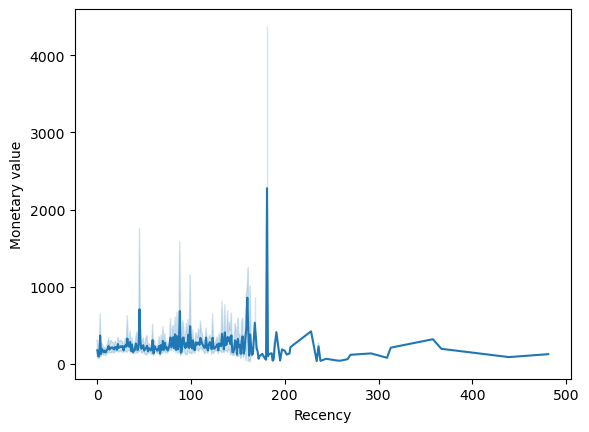

In [18]:
timeordered = rfm_dataset.sort_values(by = ["Recency"], ascending = False)
timeordered.head()
sns.lineplot(x = "Recency", y = "Monetary value", data = timeordered)

<i style ="font-size: 15px">  It is easy to see that purchases have been more frequent and people have spent more in recent days. Indeed there are a lot of changes in the recent period, while the more far people bought, the more stable total monetary value is, indicating that few people were purchasing as it is extremely unikely that most spend the same.

<p style="font-size: 16px" font-family="sans-serif">
    A frequency histplot can clear up this. In the second part we will also see how recent purchases have been way higher.

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

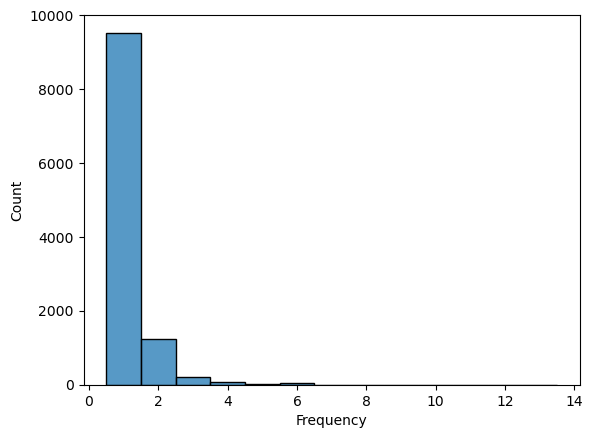

In [19]:
sns.histplot(data = rfm_dataset['Frequency'], discrete= True)

<i style ="font-size: 15px"> Frequency histplot. There are many people who have only purchased once

<p style="font-size: 16px" font-family="sans-serif">Let us also see how people spent based on the frequency. That will confirm if people who buy more, spend also more on average.

<AxesSubplot:xlabel='Frequency', ylabel='Average Spending by frequency'>

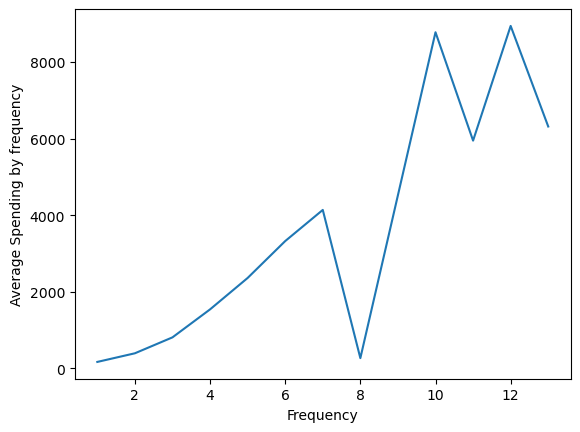

In [20]:
frd = rfm_dataset.groupby(['Frequency'])['Monetary value'].mean().reset_index(name='Average Spending by frequency')#.sort_values(['Spending by frequency'], ascending = False)

sns.lineplot(data = frd, x = "Frequency", y = "Average Spending by frequency")

<p style="font-size: 16px" font-family="sans-serif">
One can also study how payment values are distributed by creating a plot showing the frequency of payment values.

c:\Users\39339\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Monetary value'>

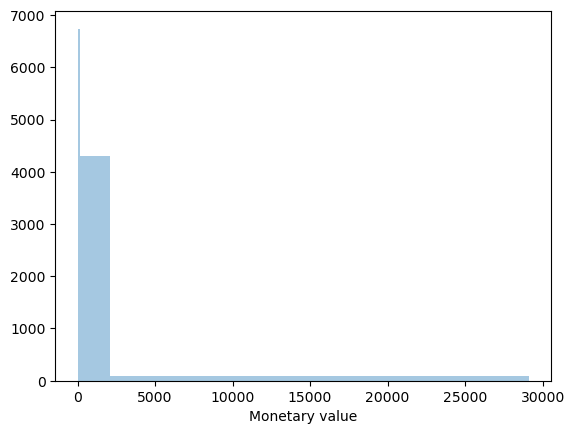

In [21]:
LogMin, LogMax = np.log10(rfm_dataset['Monetary value'].min()),np.log10(rfm_dataset['Monetary value'].max())
newbins = np.logspace(LogMin, LogMax, 4)
#applied logarithmic bins to get better visualization
sns.distplot(rfm_dataset['Monetary value'], kde=False, bins=newbins) 

In [22]:
rfm_dataset.describe()

,Recency,Monetary value,Frequency
count,11127.000000,11127.000000,11127.000000
mean,72.696055,233.694920,1.205536
std,42.547923,596.171011,0.642644
min,0.000000,10.710000,1.000000
25%,34.000000,66.420000,1.000000
50%,72.000000,118.990000,1.000000
75%,110.000000,211.875000,1.000000
max,481.000000,29099.520000,13.000000


<i style ="font-size: 15px"> An indicative description of the dataset is useful, it lets us see how spread monetary values are (likely to have few people spend a lot and many spend much less) this can be seen by the high standard deviation and by the huge inter-percentile range! (difference between max and min).

## KMeans algorithm: The most used method for clustering.

<p style="font-size: 16px" font-family="sans-serif">
We will start with the k-means algorithm for clustering. This method is known to be very effective and able to detect similarities among datapoints, relying on distance. The first thing we need to define the optimal amount of clusters to pass to our algorithm in order to minimize the within sum of clusters squares, that is, minimizing the distance among datapoints in a cluster to get better closer and stronger communities: In particular, choosing the right number of clusters maximize the distance among clusters, so that customer segmentations are clearly separable.  </p>
 

<p style="font-size: 16px" font-family="sans-serif"> 
We start by using the elbow method, which uses the WCSS to understand what is the best number of clusters to minimize the WCSS,  a measure of the variability of observations within clusters as mentioned before. </p>

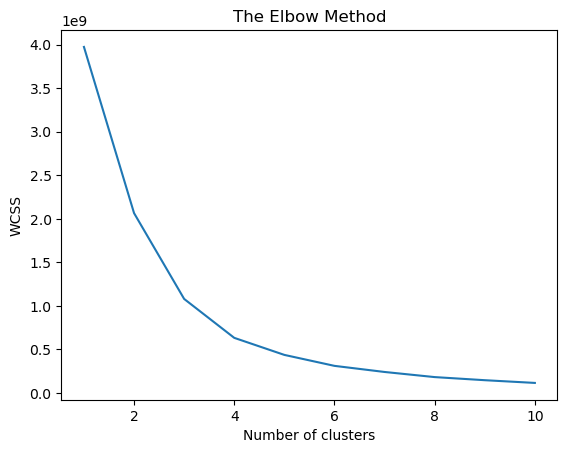

In [23]:
from sklearn.cluster import KMeans 
def elbow_method():
    features = ['Recency','Monetary value','Frequency']
    #X = rfm_dataset[features]
    wcss = []

    X = rfm_dataset[features] #numerical values non-scaled
    #X = sc_features[features] #scaled

    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, 11), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    return X 

X = elbow_method()



<i style ="font-size: 15px"> 
From the elbow method we can see that either 4 and 5 are the best number of clusters. In order to make sure that we will pick the best among all, we use Gridsearch to better interpret and tune the parameters: number of clusters, clustering algorithm and number of iterations for centroids are to be tuned in K-means!

In [24]:
from sklearn.model_selection import GridSearchCV 

params = {
    'algorithm': ['lloyd','elkan'],
    'n_init' : [i for i in range(1,15)],
    'n_clusters' : [i for i in range(3,6)]

}

kmeans =  KMeans()
clf = GridSearchCV(estimator = kmeans, param_grid= params).fit(X)



cv_results = pd.DataFrame(clf.cv_results_)
#display(cv_results)

print(f"The top parameters to tune into Kmeans are: {clf.best_params_}")


The top parameters to tune into Kmeans are: {'algorithm': 'lloyd', 'n_clusters': 5, 'n_init': 1}


<p style="font-size: 16px" font-family="sans-serif">
As we can see the parameters likely to produce better results are 'elkan' as algorithm and the number of clusters is 5 and the chosen iterations to find centroids set to 3. We can now retry to fit the model with these hypertuned parameters.
If one wants to see the results choosing the arbitrary but still appropriate parameters, can use the class below which shows the results for all parameters we tune. </p>

<p style="font-size: 16px" font-family="sans-serif">    
Below, we create a class named Kmeancust which is a customized version of the kmeans. One can choose the hyperparameters arbitrarly to visualize the points separation(clusters) and judge the ideal set of them. </p>

In [25]:

import plotly.graph_objs as go  #import pylot for 3d objects!
#doing a class that allows to change hyperparameters!
class Kmeanscust():

    def __init__(self,clusters1,algorithm1,rand_state,X, df):
        self.clusters1 = clusters1  
        self.algorithm1 = algorithm1
        self.rand_state = rand_state 
        self.X = X 
        self.df = df 

    def clustering(self, clusters1, algorithm1, rand_state,X, df):
            
            kmeans = KMeans(n_clusters = clusters1, init = 'k-means++', random_state = rand_state, algorithm = algorithm1, n_init = 3)
            y_kmeans = kmeans.fit_predict(X)
            

            #add respective client's clusters assigned 
             
            rfmcopy = df.copy()
            rfmcopy['kmeans_cluster'] = y_kmeans
            
            #in this way we can visualize the data scattered with real values instead of the scaled ones we use in the kmeans!

            plot = go.Figure()    #fig equivalent in plotly

            #a good thing to do is to use the information we stored in the dataframe! 
            #a loop will let us separate data in clusters!
            nclusters = [i for i in range (0,clusters1)]  #basically getting alist containg the ith clusters ---> e.g Let 4 be the number of clusters chosen then nclusters -> [1,2,3,4] that are the  number of clusters
            for x in nclusters:
                plot.add_trace(go.Scatter3d(x = rfmcopy[rfmcopy.kmeans_cluster == x]['Recency'], 
                                            y = rfmcopy[rfmcopy.kmeans_cluster == x]['Frequency'],
                                            z = rfmcopy[rfmcopy.kmeans_cluster == x]['Monetary value'],  
                                            mode='markers', marker_size = 8, marker_line_width = 1,
                                            name = 'Cluster ' + str(x+1)
                                            ))
                                                
        
            # changing the layout!

            plot.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                            scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                            yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                            zaxis=dict(title = 'Monetary value', titlefont_color = 'black')),
                            font = dict(family = "Gilroy", color  = 'black', size = 12))
            
            plot.show()
            return rfmcopy  

#Let us try all the feasible options:
nclusters = [3,4,5,6]
algo = ["lloyd","elkan"]
 

def choose():
    inp1 = int(input("please insert the number of clusters you would like to have:"))
    if inp1 not in nclusters:
        print("not reccomended nclusters, insert integer between 3 and 6 for an optimal result")
        inp1 = int(input("please insert the number of clusters you would like to have:"))
    inp2 = str(input("choose lloyd or elkan:"))
    if inp2 not in algo:
        print("Please type correctly the algorithm to use!")        
        inp2 = str(input("choose lloyd or elkan:"))

    inp3 = int(input("please insert a random state(integer!):"))
    if type(inp3) != int:
        print("Random state must be an integer! Please reinsert")
        inp3 = int(input("reinsert an random integer:"))



    #initialization of the object and function calling, X are the scaled features whilst rfm_dataset is the original one    
         
    obj = Kmeanscust(inp1,inp2,inp3,X, rfm_dataset)
    cl = obj.clustering(inp1,inp2,inp3,X, rfm_dataset)
    return cl  

rfmcopy = choose()


<i style ="font-size: 15px"> 
An interactive visualization of clusters. It is easy to identify the segmentations as there are few high spenders, lots of mid spenders and those who are likely to be at-risk customers or occasional ones.

<p style="font-size: 16px" font-family="sans-serif">
Sometimes, if not always, hyperparameters tuning does work in theory, but not in practice. As we clearly know, in unsupervised learning we can not quantify the accuracy of the model as we have not any variable to compare to (y variable). What we are doing though, is to compute the silhouette score, which quantifies how well the clusters are separated by taking the intra cluster distance into account. If we separate customers in 5 categories, we obtain a much lower silhouette score with respect to 3 or 4 clusters; also it seems reasonable as in general, customers are segmented in 3/4 main categories: High spenders, Mid spenders, at-risk customers(those who are likely, for random reasons, to leave the service) and low spenders, those who occasionaly buy. After trying multiple solutions we find 4 clusters as a good compromise, even though 3 clusters present an higher silhouette score, 4 segmentations perfectly represent customers' behaviour.
    <br>

In [26]:
from sklearn.metrics import silhouette_samples, silhouette_score 
resultskmeans = rfmcopy['kmeans_cluster']
silscores = {}
silscores['kmeans'] = silhouette_score(X, resultskmeans, metric='euclidean')  #creating a dataframe for sil_scores

print(f"The silhouette score for kmeans is: {silscores['kmeans']}")

The silhouette score for kmeans is: 0.8160009647776542


## HC clustering:

<p style="font-size: 16px" font-family="sans-serif">
An alternative way to cluster customers is the hierarchical clustering.
Hierarchical Clustering creates clusters in a hierarchical tree-like structure (called a Dendrogram, which we will display below). That means, a subset of similar data is created in a tree-like structure in which the root node corresponds to the entire data, and branches are created from the root node to form several clusters. This will show us again what is the right number of clusters we need to tune. </p>

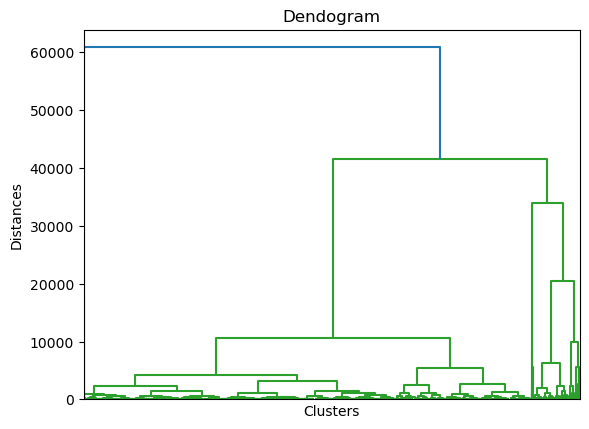

In [27]:

import scipy.cluster.hierarchy as sch         
from sklearn.cluster import AgglomerativeClustering

Dend = sch.dendrogram(sch.linkage(X, method="ward"))
plt.title("Dendogram")
plt.xlabel("Clusters")
plt.ylabel("Distances")
plt.xticks([])    #no ticks is displayed
plt.show()




<i style ="font-size: 15px"> 
It does seem that the doable range of clusters is 3 to 6. We will try all of them and see what the results look like.

<p style="font-size: 16px" font-family="sans-serif">
For the sake of consistency, we will choose 4 as the number of clusters, as it then can be comparable with the results we obtained wth the Kmeans algorithm.
In this case, there are 2 major hyperaparameters to tune, the linkage (ward and average work similarly), that is, the metrics to use to determine the distance betweeen clusters, and the affinity, what type of distance measure to use to compute such linkage.

In [28]:
#single and complete do not work well, average and Ward are pretty similar
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)  #predicting the clusters
 
# Visualising the clusters, one can either choose matplotlib(worse) or plotly as we did before
'''fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], X[y_hc == 0,2], s = 100, c = 'red', label = 'Cluster 1')
ax.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], X[y_hc == 1,2], s = 100, c = 'blue', label = 'Cluster 2')
ax.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], X[y_hc == 2,2], s = 100, c = 'green', label = 'Cluster 3')
ax.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], X[y_hc == 3,2], s = 100, c = 'cyan', label = 'Cluster 4')
ax.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], X[y_hc == 4,2], s = 100, c = 'black', label = 'Cluster 5')
ax.scatter(X[y_hc == 5, 0], X[y_hc == 5, 1], X[y_hc == 5,2], s = 100, c = 'magenta', label = 'Cluster 6')


from mpl_toolkits.mplot3d import Axes3D
plt.title('Clusters of customers')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency', rotation=45) 
plt.legend()
plt.show() ''' 

#sc_features['hc_clusters'] = y_hc  #in case we want to use scaled rfm_dataset
plot2 = go.Figure()
rfmcopy['hc_clusters'] = y_hc #inserting a new column in rfm corresponding to the i-th cluster for each customer

n2clusters = sorted(list(rfmcopy['hc_clusters'].unique()))   #same as we did before, the y_hc is a numpy array that returns, for each customer, the corresponding cluster assigned.
for x in n2clusters:
        plot2.add_trace(go.Scatter3d(x = rfmcopy[rfmcopy.hc_clusters == x]['Recency'], 
                                    y = rfmcopy[rfmcopy.hc_clusters == x]['Frequency'],
                                    z = rfmcopy[rfmcopy.hc_clusters == x]['Monetary value'],  
                                    mode='markers', marker_size = 8, marker_line_width = 1,
                                    name = 'Cluster ' + str(x+1)
                                    ))
                                                
                                            
# changing the layout!

plot2.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Monetary value', titlefont_color = 'black')),
                font = dict(family = "Gilroy", color  = 'black', size = 12))

plot2.show()


<i style ="font-size: 15px"> 
At this stage, things do not seem to change with Agglomerative clustering: the hierarchical method has found almost the same clusters of the previous method and this is seen with the silhouette score below too, which is slighter less than the kmeans one.

In [29]:
silscores['hierarchical clustering'] = silhouette_score(X, y_hc, metric='euclidean')

print(f"The silhouette score for Hierarchical clustering is: {silscores['hierarchical clustering']}")

The silhouette score for Hierarchical clustering is: 0.7904401494191384


## Spectral clustering

<p style="font-size: 16px" font-family="sans-serif">
Another idea, may be to implement the spectral clustering to check if that works better(especially for a lower number of clusters). As we can notice, the final centroids do not describe the clusters well. They are all pretty close even though clusters are distinctly separated as also shown by the silhouette score. The spectral clustering basically creates an affinity matrix, where each datapoint is compared to others by assessing the "similarity", that is, sklearn builds a graph with datapoints as nodes, and uses the number of common neigbors(nearest) to identify specific communities.

In [30]:

from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(
    n_clusters=4, 
    random_state=42, 
    n_neighbors=8, 
    affinity='nearest_neighbors')

sp = spectral.fit_predict(X)

#plotting the results


'''fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[sp== 0, 0], X[sp == 0, 1], X[sp == 0,2], s = 100, c = 'red', label = 'Cluster 1')
ax.scatter(X[sp== 1, 0], X[sp == 1, 1], X[sp == 1,2], s = 100, c = 'blue', label = 'Cluster 2')
ax.scatter(X[sp== 2, 0], X[sp == 2, 1], X[sp == 2,2], s = 100, c = 'green', label = 'Cluster 3')
ax.scatter(X[sp== 3, 0], X[sp == 3, 1], X[sp == 3,2], s = 100, c = 'cyan', label = 'Cluster 4')
ax.scatter(X[sp== 4, 0], X[sp == 4, 1], X[sp == 4,2], s = 100, c = 'black', label = 'Cluster 5')

from mpl_toolkits.mplot3d import Axes3D
plt.title('Clusters of customers')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency', rotation=45) 
plt.legend()
plt.show() ''' 


plot3 = go.Figure()

rfmcopy['sp_clusters'] = sp  
n3clusters = sorted(list(rfmcopy['sp_clusters'].unique()))   #same as we did before, the y_hc is a numpy array that returns, for each customer, the corresponding cluster assigned.
for x in n3clusters:
        plot3.add_trace(go.Scatter3d(x = rfmcopy[rfmcopy.sp_clusters == x]['Recency'], 
                                    y = rfmcopy[rfmcopy.sp_clusters == x]['Frequency'],
                                    z = rfmcopy[rfmcopy.sp_clusters == x]['Monetary value'],  
                                    mode='markers', marker_size = 8, marker_line_width = 1,
                                    name = 'Cluster ' + str(x+1)
                                    ))
                                                
                                            

            # changing the layout!

plot3.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'red'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'blue'),
                                zaxis=dict(title = 'Monetary value', titlefont_color = 'green')),
                font = dict(family = "Gilroy", color  = 'black', size = 12))

plot3.show()




<i style ="font-size: 15px"> 
This method does not work as good as the others; even though the cluster separation is fine, the clustering  identifies too many high spenders and too few risk-customers, our EDA has shown that actually few people have spent a lot, and many spend the same.

<p style="font-size: 16px" font-family="sans-serif">
Finally we will display all the silhouette scores for each algorithm.

In [31]:
silscores['Spectral clustering'] = silhouette_score(X, sp, metric='euclidean')

dfscores = pd.DataFrame(silscores, index = [0])
display(dfscores)


,kmeans,hierarchical clustering,Spectral clustering
0,0.816001,0.79044,0.34288


<i style ="font-size: 15px">  Silhouette score by algorithm.

In [32]:
rfmcopy.head()

,Customer ID,Recency,Monetary value,Frequency,kmeans_cluster,hc_clusters,sp_clusters
0,001051abfcfdbed9f87b4266213a5df1,91,65.20,3,1,2,0
1,0013cd8e350a7cc76873441e431dd5ee,113,92.60,1,1,2,1
2,0015bc9fd2d5395446143e8b215d7c75,78,132.19,1,1,2,1
3,0018c09f333634ca9c80d9ff46e43e9c,58,56.87,1,1,2,0
4,001df1ee5c36767aa607001ab1a13a06,23,42.86,1,1,2,0


## Final consideration on the three methods:


<p style="font-size: 16px" font-family="sans-serif">
As we have seen, HC and KMeans methods outperform the spectral clustering  on clustering visualization and detection, as shown also by the silhouette score.
In the SC implementation, the algorithm seems not to distinguish between mid and high spenders, making them a unique community. The other 2 algorithms instead are way more indicative as it is easy to understand how they weighted each of the 3 RFM features to cluster; they emphasized mostly on the monetary value and frequency rather than the recency (which is legit by the way). What we want to do now is to collect further infomation on the whole dataset (the original one) and try to find another way to cluster. Let us first of all collect relevant information about each cluster detected by KMeans algorithm and HC.

In [33]:
cl1size = len(rfmcopy[rfmcopy['kmeans_cluster'] == 0])
cl1sum = rfmcopy[rfmcopy['kmeans_cluster'] == 0]['Monetary value'].sum()
cl1mean = rfmcopy[rfmcopy['kmeans_cluster'] == 0]['Monetary value'].mean()
cl1frequency = rfmcopy[rfmcopy['kmeans_cluster'] == 0]['Frequency'].mean()
#cl1sd = rfmcopy[rfmcopy['kmeans_cluster'] == 0]['Monetary value'].min()
#cl1sd = rfmcopy[rfmcopy['kmeans_cluster'] == 0]['Monetary value'].max()
cl1fsd = rfmcopy[rfmcopy['kmeans_cluster'] == 0]['Frequency'].std()
cl1sd = rfmcopy[rfmcopy['kmeans_cluster'] == 0]['Monetary value'].std()

#second
cl2size = len(rfmcopy[rfmcopy['kmeans_cluster'] == 1]) 
cl2sum = rfmcopy[rfmcopy['kmeans_cluster'] == 1]['Monetary value'].sum()
cl2mean = rfmcopy[rfmcopy['kmeans_cluster'] == 1]['Monetary value'].mean()
cl2frequency = rfmcopy[rfmcopy['kmeans_cluster'] == 1]['Frequency'].mean()
cl2fsd = rfmcopy[rfmcopy['kmeans_cluster'] == 1]['Frequency'].std()
cl2sd = rfmcopy[rfmcopy['kmeans_cluster'] == 1]['Monetary value'].std()


#third
cl3size = len(rfmcopy[rfmcopy['kmeans_cluster'] == 2])
cl3sum =  rfmcopy[rfmcopy['kmeans_cluster'] == 2]['Monetary value'].sum()
cl3mean = rfmcopy[rfmcopy['kmeans_cluster'] == 2]['Monetary value'].mean()
cl3frequency = rfmcopy[rfmcopy['kmeans_cluster'] == 2]['Frequency'].mean()
cl3fsd = rfmcopy[rfmcopy['kmeans_cluster'] == 2]['Frequency'].std()
cl3sd = rfmcopy[rfmcopy['kmeans_cluster'] == 2]['Monetary value'].std()

#fourth

cl4size = len(rfmcopy[rfmcopy['kmeans_cluster'] == 3])
cl4sum = rfmcopy[rfmcopy['kmeans_cluster'] == 3]['Monetary value'].sum()
cl4mean = rfmcopy[rfmcopy['kmeans_cluster'] == 3]['Monetary value'].mean()
cl4frequency = rfmcopy[rfmcopy['kmeans_cluster'] == 3]['Frequency'].mean()
cl4fsd = rfmcopy[rfmcopy['kmeans_cluster'] == 3]['Frequency'].std()
cl4sd = rfmcopy[rfmcopy['kmeans_cluster'] == 3]['Monetary value'].std()

#fifth(if it exists)
'''cl5size = len(rfmcopy[rfmcopy['kmeans_cluster'] == 4])
cl5sum = rfmcopy[rfmcopy['kmeans_cluster'] == 4]['Monetary value'].sum()
cl5mean = rfmcopy[rfmcopy['kmeans_cluster'] == 4]['Monetary value'].mean()
cl5frequency = rfmcopy[rfmcopy['kmeans_cluster'] == 4]['Frequency'].mean() '''




"cl5size = len(rfmcopy[rfmcopy['kmeans_cluster'] == 4])\ncl5sum = rfmcopy[rfmcopy['kmeans_cluster'] == 4]['Monetary value'].sum()\ncl5mean = rfmcopy[rfmcopy['kmeans_cluster'] == 4]['Monetary value'].mean()\ncl5frequency = rfmcopy[rfmcopy['kmeans_cluster'] == 4]['Frequency'].mean() "

In [34]:
dictio2 = {'Clustersize': [cl1size,cl2size,cl3size, cl4size], 'Total spending by cluster': [cl1sum,cl2sum,cl3sum,cl4sum],
         'Average spending by cluster' : [cl1mean,cl2mean,cl3mean,cl4mean], 'Average frequency by cluster':
           [cl1frequency ,cl2frequency ,cl3frequency ,cl4frequency], 'Frequency std': [cl1fsd,cl2fsd,cl3fsd,cl4fsd], 'Spending sd':
          [cl1sd,cl2sd,cl3sd,cl4sd]}

Kmeanssummary = pd.DataFrame(dictio2, index = [1,2,3,4])  #include 5 if 5 is chosen

In [35]:
Kmeanssummary.head()

,Clustersize,Total spending by cluster,Average spending by cluster,Average frequency by cluster,Frequency std,Spending sd
1,687,768355.96,1118.422067,2.052402,1.393505,492.269727
2,10393,1526673.21,146.894372,1.132493,0.406424,119.367568
3,5,95185.46,19037.092000,6.400000,3.286335,6342.191347
4,42,210108.74,5002.589048,4.809524,2.587381,1848.748169


<i style ="font-size: 15px"> A summary of the clusters detected by Kmeans. Respectively, row 1 indicates relatively mid-spenders who bought more than once; the third and fourth cluster instead have people who spend much more (high-spenders) and with an higher frequency than others, they can be also considered as a unique cluster. Finally, the majority of people is considered by kmeans as "at-risk customers", that is, those who buy and spend less; this cluster seems the most accurate since the standard deviation for both the frequency and the total spending per customer is relatively small when compared to other clusters.

In [36]:
#same for hierarchical
cl1size = len(rfmcopy[rfmcopy['hc_clusters'] == 0])
cl1sum = rfmcopy[rfmcopy['hc_clusters'] == 0]['Monetary value'].sum()
cl1mean = rfmcopy[rfmcopy['hc_clusters'] == 0]['Monetary value'].mean()
cl1frequency = rfmcopy[rfmcopy['hc_clusters'] == 0]['Frequency'].mean()
cl1fsd = rfmcopy[rfmcopy['hc_clusters'] == 0]['Frequency'].std()
cl1sd = rfmcopy[rfmcopy['hc_clusters'] == 0]['Monetary value'].std()

#second
cl2size = len(rfmcopy[rfmcopy['hc_clusters'] == 1]) 
cl2sum = rfmcopy[rfmcopy['hc_clusters'] == 1]['Monetary value'].sum()
cl2mean = rfmcopy[rfmcopy['hc_clusters'] == 1]['Monetary value'].mean()
cl2frequency = rfmcopy[rfmcopy['hc_clusters'] == 1]['Frequency'].mean()
cl2fsd = rfmcopy[rfmcopy['hc_clusters'] == 1]['Frequency'].std()
cl2sd = rfmcopy[rfmcopy['hc_clusters'] == 1]['Monetary value'].std()

#third
cl3size = len(rfmcopy[rfmcopy['hc_clusters'] == 2])
cl3sum =  rfmcopy[rfmcopy['hc_clusters'] == 2]['Monetary value'].sum()
cl3mean = rfmcopy[rfmcopy['hc_clusters'] == 2]['Monetary value'].mean()
cl3frequency = rfmcopy[rfmcopy['hc_clusters'] == 2]['Frequency'].mean()
cl3fsd = rfmcopy[rfmcopy['hc_clusters'] == 2]['Frequency'].std()
cl3sd = rfmcopy[rfmcopy['hc_clusters'] == 2]['Monetary value'].std()


#fourth
cl4size = len(rfmcopy[rfmcopy['hc_clusters'] == 3])
cl4sum = rfmcopy[rfmcopy['hc_clusters'] == 3]['Monetary value'].sum()
cl4mean = rfmcopy[rfmcopy['hc_clusters'] == 3]['Monetary value'].mean()
cl4frequency = rfmcopy[rfmcopy['hc_clusters'] == 3]['Frequency'].mean()
cl4fsd = rfmcopy[rfmcopy['hc_clusters'] == 3]['Frequency'].std()
cl4sd = rfmcopy[rfmcopy['hc_clusters'] == 3]['Monetary value'].std()  

In [37]:
dictio3 = {'Clustersize': [cl1size,cl2size,cl3size, cl4size], 'Total spending by cluster': [cl1sum,cl2sum,cl3sum,cl4sum],
         'Average spending by cluster' : [cl1mean,cl2mean,cl3mean,cl4mean], 'Average frequency by cluster':
           [cl1frequency ,cl2frequency ,cl3frequency ,cl4frequency], 'Frequency std': [cl1fsd,cl2fsd,cl3fsd,cl4fsd], 'Spending sd':
          [cl1sd,cl2sd,cl3sd,cl4sd]}
Hcsummary = pd.DataFrame(dictio3, index = [1,2,3,4])

In [38]:
Hcsummary.head()

,Clustersize,Total spending by cluster,Average spending by cluster,Average frequency by cluster,Frequency std,Spending sd
1,1048,999769.80,953.978817,1.935115,1.259761,543.790685
2,6,106653.91,17775.651667,6.500000,2.949576,6459.574533
3,10044,1334976.67,132.912850,1.114098,0.370048,94.105004
4,29,158922.99,5480.103103,5.413793,2.612022,1426.240780


<i style ="font-size: 15px">
A remarkable difference between clusters is visible. As one can notice, top-spenders are clustered in the second cluster, representing an insignificant part of the sample (they should be merged with fourth cluster) and they spend much more and with much higher frequency than others. The majority of people are mid or relatively high spenders(cluster 1). The customer who needs the most advertisment and email are the majority, in cluster 3.

In [39]:
#same for spectral
cl1size = len(rfmcopy[rfmcopy['sp_clusters'] == 0])
cl1sum = rfmcopy[rfmcopy['sp_clusters'] == 0]['Monetary value'].sum()
cl1mean = rfmcopy[rfmcopy['sp_clusters'] == 0]['Monetary value'].mean()
cl1frequency = rfmcopy[rfmcopy['sp_clusters'] == 0]['Frequency'].mean()
cl1fsd = rfmcopy[rfmcopy['sp_clusters'] == 0]['Frequency'].std()
cl1sd = rfmcopy[rfmcopy['sp_clusters'] == 0]['Monetary value'].std()


#second
cl2size = len(rfmcopy[rfmcopy['sp_clusters'] == 1]) 
cl2sum = rfmcopy[rfmcopy['sp_clusters'] == 1]['Monetary value'].sum()
cl2mean = rfmcopy[rfmcopy['sp_clusters'] == 1]['Monetary value'].mean()
cl2frequency = rfmcopy[rfmcopy['sp_clusters'] == 1]['Frequency'].mean()
cl2fsd = rfmcopy[rfmcopy['sp_clusters'] == 1]['Frequency'].std()
cl2sd = rfmcopy[rfmcopy['sp_clusters'] == 1]['Monetary value'].std()


#third
cl3size = len(rfmcopy[rfmcopy['sp_clusters'] == 2])
cl3sum =  rfmcopy[rfmcopy['sp_clusters'] == 2]['Monetary value'].sum()
cl3mean = rfmcopy[rfmcopy['sp_clusters'] == 2]['Monetary value'].mean()
cl3frequency = rfmcopy[rfmcopy['sp_clusters'] == 2]['Frequency'].mean()
cl3fsd = rfmcopy[rfmcopy['sp_clusters'] == 2]['Frequency'].std()
cl3sd = rfmcopy[rfmcopy['sp_clusters'] == 2]['Monetary value'].std()

#fourth
cl4size = len(rfmcopy[rfmcopy['sp_clusters'] == 3])
cl4sum = rfmcopy[rfmcopy['sp_clusters'] == 3]['Monetary value'].sum()
cl4mean = rfmcopy[rfmcopy['sp_clusters'] == 3]['Monetary value'].mean()
cl4frequency = rfmcopy[rfmcopy['sp_clusters'] == 3]['Frequency'].mean()
cl4fsd = rfmcopy[rfmcopy['sp_clusters'] == 3]['Frequency'].std()
cl4sd = rfmcopy[rfmcopy['sp_clusters'] == 3]['Monetary value'].std() 

In [40]:
dictio4 = {'Clustersize': [cl1size,cl2size,cl3size, cl4size], 'Total spending by cluster': [cl1sum,cl2sum,cl3sum,cl4sum],
         'Average spending by cluster' : [cl1mean,cl2mean,cl3mean,cl4mean], 'Average frequency by cluster':
           [cl1frequency ,cl2frequency ,cl3frequency ,cl4frequency], 'Frequency std': [cl1fsd,cl2fsd,cl3fsd,cl4fsd], 'Spending sd':
          [cl1sd,cl2sd,cl3sd,cl4sd]}

Spsummary = pd.DataFrame(dictio4, index = [1,2,3,4])

In [41]:
Spsummary.head()    

,Clustersize,Total spending by cluster,Average spending by cluster,Average frequency by cluster,Frequency std,Spending sd
1,4292,257026.22,59.884953,1.044501,0.232773,23.185643
2,5380,923693.78,171.690294,1.138476,0.400278,69.221703
3,246,656481.22,2668.622846,2.918699,2.237322,2906.197008
4,1209,763122.15,631.201117,1.727047,0.949000,217.549459


<i style ="font-size: 15px">
This is a surprising result. Even though kmeans and hierarchical seemed better when visualizing the clusters, the spectral algorithm is much more balanced when it comes to size distribution per cluster and standard deviation in monetary value and frequency ; We notice that both algorithm have detected a small number of people who spent much more than the others but detected a group, based on size and average spending is likely to be made of outliers and hence not useful for our customer segmentation. From these dataframes is also clear that there exists some customer in the third cluster of spectral(high-spenders) who buy frequently and spend much more than others. In the spectral, cluster 1 contains people who have bought just once(presumably looking at the average frequency) and they can be considered as "occasional customers" who should be engaged by the subsidiary and more emails must be sent to them. The second cluster instead contains "at-risk customers" who likely purchased once and less than the other categories by far, it is important to send as many emails as possible to retain them. The third cluster has "top/high-spenders" which buy and spend more than others. The fourth cluster instead, contains "mid-spenders or abitual customers" who have purchased more than once; target emails with specific products should be enough to retain them.

<p style="font-size: 16px" font-family="sans-serif">
One can also visualizing clearer the results of the different clusters using displots, to see how the customer population is distributed based on the 3 features we have.

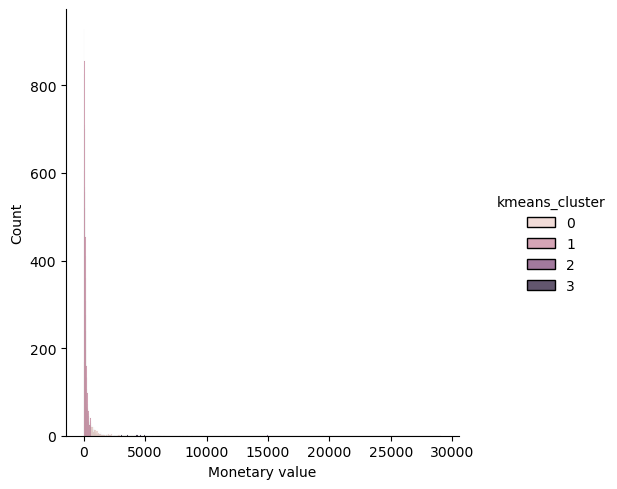

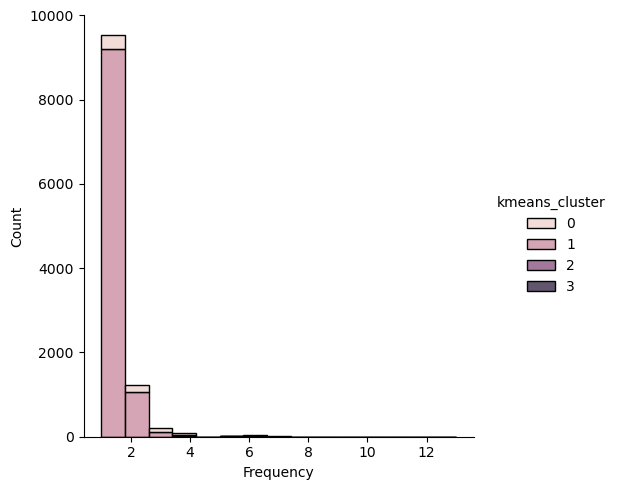

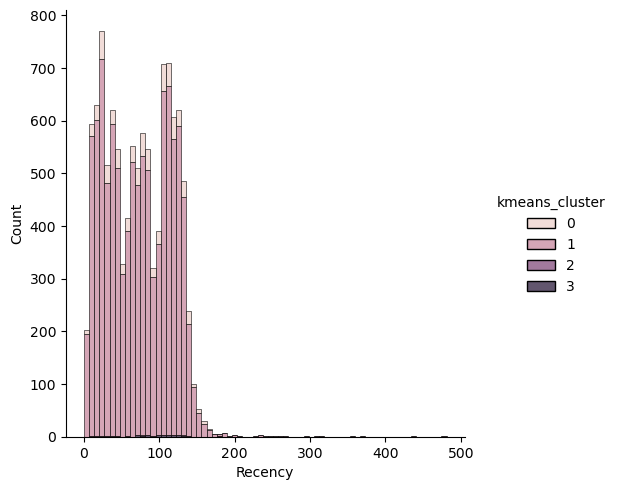

In [42]:
#displot of kmeans clusters
#from sklearn.preprocessing import MinMaxScaler
scaledrfm = rfmcopy.copy()
#sc = MinMaxScaler()
#new = sc.fit_transform(scaledrfm['Monetary value'].array.reshape(-1,1)) #getting data less screwed
#scaledrfm['Monetary value'] = new
sns.set_palette("Dark2")
sns.displot(data = scaledrfm , x = 'Monetary value', hue = "kmeans_cluster", multiple = "stack")
sns.displot(data = scaledrfm , x = "Frequency" , hue = "kmeans_cluster", multiple = "stack")
sns.displot(data = scaledrfm , x = "Recency" , hue = "kmeans_cluster", multiple = "stack")


<p style="font-size: 16px" font-family="sans-serif">
As hierarchical and kmeans present similar characteristics, we will see the distribution of the spectral clustering to check for some differences.

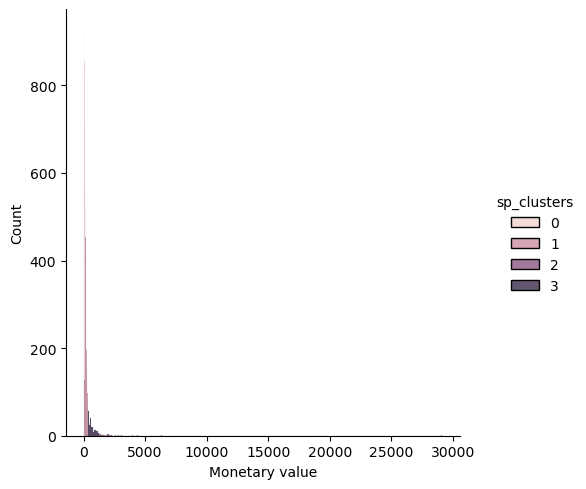

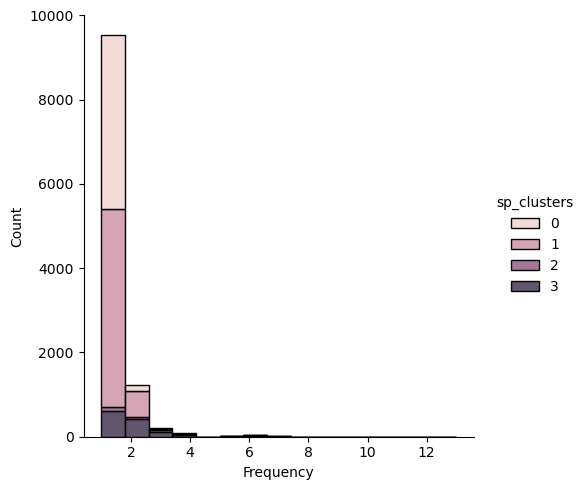

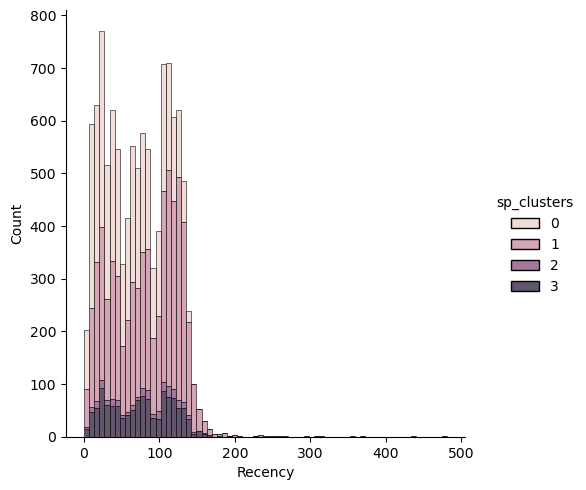

In [43]:
#we will do the same with the spectral clusetring that is more balanced
sns.set_palette("colorblind", 4)
sns.displot(data = scaledrfm , x = 'Monetary value', hue = "sp_clusters", multiple = "stack")
sns.displot(data = scaledrfm , x = "Frequency" , hue = "sp_clusters", multiple = "stack")
sns.displot(data = scaledrfm , x = "Recency" , hue = "sp_clusters", multiple = "stack")

<i style ="font-size: 15px">
As we observe, it does not seem convenient to display the smallest clusters(top and high spenders) as separate but rather, as a unique cluster as their population is not significant enough.

<p style="font-size: 16px" font-family="sans-serif">
Let us first analyze the customer behaviour of low spenders. We will compare and see insightful patterns and understand which algorithm better detected this customer segmentation.
To get started, we regroup the clusters in 3 categories, as we noticed that some clusters in the 3 algorithms present very similar characteristics and it is hence not useful to leave clusters with only a few customers (these represent top customers that spend much more than others or have purchased expensive products).

In [44]:
#creating one dataframe for each category detected by algorithms
feat = ['Recency', 'Frequency', 'Monetary value']
#low/at-risk/occasional customers
lowspenderskmeans = rfmcopy[rfmcopy['kmeans_cluster'] == 1][feat]  #getting only rfm features
lowspendershc = rfmcopy[rfmcopy['hc_clusters'] == 2][feat]
lowspenderssc = rfmcopy[rfmcopy['sp_clusters'] == 0][feat]



#mid-spenders 
midspenderssp = rfmcopy[(rfmcopy['sp_clusters'] == 1) | (rfmcopy['sp_clusters'] == 3)][feat]
midspendershc = rfmcopy[rfmcopy['hc_clusters'] == 0][feat]
midspenderskm = rfmcopy[rfmcopy['kmeans_cluster'] == 0][feat]

#high/top spenders in the case of kmeans and hc we will merge them, as there are few outliers which contribute to a tiny cluster
#for the sake of completeness, also in the spectral the sthird and fourth will be merged
highspenderssc = rfmcopy[ (rfmcopy['sp_clusters'] == 2)][feat]
highspendershc = rfmcopy[(rfmcopy['hc_clusters'] == 3) | (rfmcopy['hc_clusters'] == 1)][feat]
highspenderskm = rfmcopy[(rfmcopy['kmeans_cluster'] == 2) | (rfmcopy['kmeans_cluster'] == 3)][feat]




<p style="font-size: 16px" font-family="sans-serif">
As hierarchical and kmeans present very similar results we will choose kmeans due to its slightly higher silhouette score. Below, we will compare clusters of spectral with the kmeans ones

In [45]:
lowspenderskmeans.describe() 

,Recency,Frequency,Monetary value
count,10393.000000,10393.000000,10393.000000
mean,72.339748,1.132493,146.894372
std,42.632698,0.406424,119.367568
min,0.000000,1.000000,10.710000
25%,34.000000,1.000000,63.650000
50%,71.000000,1.000000,111.780000
75%,110.000000,1.000000,185.860000
max,481.000000,8.000000,630.280000


In [46]:
lowspenderssc.describe()

,Recency,Frequency,Monetary value
count,4292.000000,4292.000000,4292.000000
mean,59.737418,1.044501,59.884953
std,37.353655,0.232773,23.185643
min,0.000000,1.000000,10.710000
25%,27.000000,1.000000,41.277500
50%,56.000000,1.000000,57.405000
75%,91.000000,1.000000,77.015000
max,146.000000,4.000000,116.380000


<p style="font-size: 16px" font-family="sans-serif">
Let us know see the midspenders in both kmeans and spectral clustering.

In [47]:
midspenderskm.describe()

,Recency,Frequency,Monetary value
count,687.000000,687.000000,687.000000
mean,77.023290,2.052402,1118.422067
std,41.085767,1.393505,492.269727
min,0.000000,1.000000,634.000000
25%,39.000000,1.000000,762.935000
50%,79.000000,2.000000,928.960000
75%,112.000000,3.000000,1309.370000
max,168.000000,12.000000,2928.240000


In [48]:
midspenderssp.describe()

,Recency,Frequency,Monetary value
count,6589.000000,6589.000000,6589.000000
mean,80.898771,1.246471,256.004846
std,43.690210,0.589800,210.308832
min,0.000000,1.000000,23.290000
25%,41.000000,1.000000,128.480000
50%,84.000000,1.000000,176.880000
75%,117.000000,1.000000,288.370000
max,481.000000,8.000000,1237.280000


In [49]:
highspenderskm.describe()

,Recency,Frequency,Monetary value
count,47.000000,47.000000,47.000000
mean,88.234043,4.978723,6495.621277
std,39.068064,2.674268,5067.142161
min,12.000000,1.000000,3064.950000
25%,69.000000,3.000000,3710.565000
50%,95.000000,5.000000,4681.780000
75%,115.000000,6.000000,6320.130000
max,181.000000,13.000000,29099.520000


In [50]:
highspenderssc.describe()

,Recency,Frequency,Monetary value
count,246.000000,246.000000,246.000000
mean,79.081301,2.918699,2668.622846
std,40.655967,2.237322,2906.197008
min,3.000000,1.000000,1234.440000
25%,41.000000,1.000000,1434.100000
50%,86.500000,2.000000,1864.905000
75%,111.000000,4.000000,2507.557500
max,181.000000,13.000000,29099.520000


<i style ="font-size: 15px">
The two algorithms took a different approach. Whilst kmeans has taken into account the frequency much more, the spectral clustering seems not to distinguish and give importance to that parameter. Also, kmeans do cluster in a more decisive way; we previously saw that there are top clients who spend much more, but spectral has not detected them but instead, merge with others high spenders.

## Further data exploration
#### In this section we will try to find some common patterns and insights in the dataset to confirm or reassess the results we got in clustering.  As we only used the RFM dataframe which contained little if none information on the products and sellers, now we dive into these aspects.

<p style="font-size: 16px" font-family="sans-serif">
Is there correlation in payment methods? Do people spend more when making more installments? what product are the most popular?
We will try to answer all these questions, pointing out differences in customers also relying on clustering results.

<p style="font-size: 16px" font-family="sans-serif">
Let us see if there exists some correlation among payment features, that is, understand if particular payments impy more spending or viceversa in the clusters we obtained.

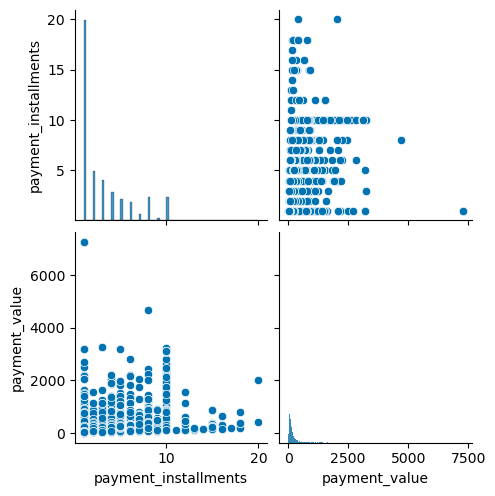

In [51]:
columns=["payment_type","payment_installments","payment_value"]
sns.pairplot(df[columns])


<p style="font-size: 16px" font-family="sans-serif">
 As one can easily see from the pairplot, there is an intersting thing. People who spend less per order, are those who make the more installments, whilst people who spend more per order, make less installment to pay (payment_installments < 10).
 It would be interesting to see if there exists correlation between them.

In [52]:
df[columns].corr()

,payment_installments,payment_value
payment_installments,1.000000,0.303847
payment_value,0.303847,1.000000


<i style ="font-size: 15px">
There is a tiny positive correlation between them; this something not remarkable and hence will not make an impact.

<p style="font-size: 16px" font-family="sans-serif">
We now want to see, for each method we used, what is the payment method used per cluster, and how many installments were made on average.

In [53]:
#we will consider the mean of installments made by the customer
installments = df.groupby(
    by=['customer_id'], as_index=False)['payment_installments'].mean()

#most used payment method by customer
paymentty = df.groupby(
    by=['customer_id'], as_index=False)['payment_type'].max()

installments.head()

,customer_id,payment_installments
0,001051abfcfdbed9f87b4266213a5df1,1.0
1,0013cd8e350a7cc76873441e431dd5ee,9.0
2,0015bc9fd2d5395446143e8b215d7c75,2.0
3,0018c09f333634ca9c80d9ff46e43e9c,5.0
4,001df1ee5c36767aa607001ab1a13a06,2.0


In [54]:
w = installments.iloc[:, [1]]
w.reset_index(drop=True, inplace=True)
n = paymentty.iloc[:,[1]]
n.reset_index(drop=True, inplace=True)

In [55]:
paydf = pd.concat([rfmcopy,w,n], axis=1) #create the df containing all info.
paydf.head()       

,Customer ID,Recency,Monetary value,Frequency,kmeans_cluster,hc_clusters,sp_clusters,payment_installments,payment_type
0,001051abfcfdbed9f87b4266213a5df1,91,65.20,3,1,2,0,1.0,voucher
1,0013cd8e350a7cc76873441e431dd5ee,113,92.60,1,1,2,1,9.0,credit_card
2,0015bc9fd2d5395446143e8b215d7c75,78,132.19,1,1,2,1,2.0,credit_card
3,0018c09f333634ca9c80d9ff46e43e9c,58,56.87,1,1,2,0,5.0,credit_card
4,001df1ee5c36767aa607001ab1a13a06,23,42.86,1,1,2,0,2.0,credit_card


#### After this set up we can now start inspecting some payment features insights for each clusters identified by the 3 algorithms

In [56]:
#some insights about payment features in kmeans clusters
clusterstype = ['mid-spenders','at-risk customers', 'top-customers','high-spenders']
paydict = {}
for i in range(4):
    countpay = paydf[paydf['kmeans_cluster'] == i]['payment_type'].value_counts() #how payment_type is distributed 
    meaninst = paydf[paydf['kmeans_cluster'] == i]['payment_installments'].mean() #average payment installments per cluster
    paydict[i+1] = {'cluster'+str(i+1):[countpay,meaninst]}
    
    print("")
    print(f"The payment distribution for the cluster made by {clusterstype[i]} of kmeans is")
    print(countpay)
    print("")
    print(f"The average installments made by customers in cluster of {clusterstype[i]} is {meaninst}")
    print("---------------------------------")



The payment distribution for the cluster made by mid-spenders of kmeans is
credit_card    550
boleto         103
debit_card      19
voucher         15
Name: payment_type, dtype: int64

The average installments made by customers in cluster of mid-spenders is 5.52304706453178
---------------------------------

The payment distribution for the cluster made by at-risk customers of kmeans is
credit_card    7805
boleto         1925
voucher         365
debit_card      298
Name: payment_type, dtype: int64

The average installments made by customers in cluster of at-risk customers is 2.7656114692581544
---------------------------------

The payment distribution for the cluster made by top-customers of kmeans is
boleto         3
credit_card    2
Name: payment_type, dtype: int64

The average installments made by customers in cluster of top-customers is 4.6
---------------------------------

The payment distribution for the cluster made by high-spenders of kmeans is
credit_card    29
boleto      

<p style="font-size: 16px" font-family="sans-serif">
The same is done with hierarchical and spectral respectively:

In [57]:
#some insight on payment features in hierarchical
customersHc = ['Mid-spenders','top customers','at-risk customers', 'high-spenders']
paydict2 = {}
for i in range(4):
    countpay = paydf[paydf['hc_clusters'] == i]['payment_type'].value_counts() #how payment_type is distributed 
    meaninst = paydf[paydf['hc_clusters'] == i]['payment_installments'].mean() #average payment installments per cluster
    paydict2[i+1] = {'cluster'+str(i+1):[countpay,meaninst]}
    
    print(f"The payment distribution for the cluster {customersHc[i]} of HC is")
    print(countpay)
    print(f"The average installments made by customers in cluster {customersHc[i]} is {meaninst}")
    print("---------------------------------")

The payment distribution for the cluster Mid-spenders of HC is
credit_card    837
boleto         163
debit_card      27
voucher         21
Name: payment_type, dtype: int64
The average installments made by customers in cluster Mid-spenders is 5.2484096692111954
---------------------------------
The payment distribution for the cluster top customers of HC is
credit_card    3
boleto         3
Name: payment_type, dtype: int64
The average installments made by customers in cluster top customers is 4.0
---------------------------------
The payment distribution for the cluster at-risk customers of HC is
credit_card    7528
boleto         1867
voucher         359
debit_card      290
Name: payment_type, dtype: int64
The average installments made by customers in cluster at-risk customers is 2.700617283950617
---------------------------------
The payment distribution for the cluster high-spenders of HC is
credit_card    18
boleto         11
Name: payment_type, dtype: int64
The average installments


<p style="font-size: 16px" font-family="sans-serif">Ultimately spectral has:

In [58]:
#some insight on payment features in spectral
customersSp = ['Low spenders', 'at-risk customers','top customers', 'High spenders']
paydict3 = {}
for i in range(4):
    countpay = paydf[paydf['sp_clusters'] == i]['payment_type'].value_counts() #how payment_type is distributed 
    meaninst = paydf[paydf['sp_clusters'] == i]['payment_installments'].mean() #average payment installments per cluster
    paydict3[i+1] = {'cluster'+str(i+1):[countpay,meaninst]}
    
    print(f"The payment distribution for the cluster {customersSp[i]} of Spectral is")
    print(countpay)
    print(f"The average installments made by customers in cluster {customersSp[i]} is {meaninst}")
    print("---------------------------------")

The payment distribution for the cluster Low spenders of Spectral is
credit_card    3050
boleto          905
voucher         199
debit_card      138
Name: payment_type, dtype: int64
The average installments made by customers in cluster Low spenders is 1.8685538987263124
---------------------------------
The payment distribution for the cluster at-risk customers of Spectral is
credit_card    4171
boleto          915
voucher         153
debit_card      141
Name: payment_type, dtype: int64
The average installments made by customers in cluster at-risk customers is 3.2504027261462203
---------------------------------
The payment distribution for the cluster top customers of Spectral is
credit_card    191
boleto          44
debit_card       6
voucher          5
Name: payment_type, dtype: int64
The average installments made by customers in cluster top customers is 6.014227642276423
---------------------------------
The payment distribution for the cluster High spenders of Spectral is
credit_c

<i style ="font-size: 15px">
There is a general trend going on above. Those who are considered top and high spenders prefer using credit cards and boleto as payment method, whilst some low, at-risk customers have used vouchers and hence it is likely that they have got the voucher from someone and are not usual customers who buy frequently; Moreover, one can notice that top and mid spenders make less installments than others. These features can be used to use other methods to identify clusters in a more efficient way, as they seem to contribute when it comes to customer segmentation.

### We already saw the frequency and the monetary value of each customer, and their distribution, but what about the purchase recency? Below, an histplot lets us see how many customers have purchased per each period of time.

<AxesSubplot:xlabel='days since last purchase', ylabel='number of people per period'>

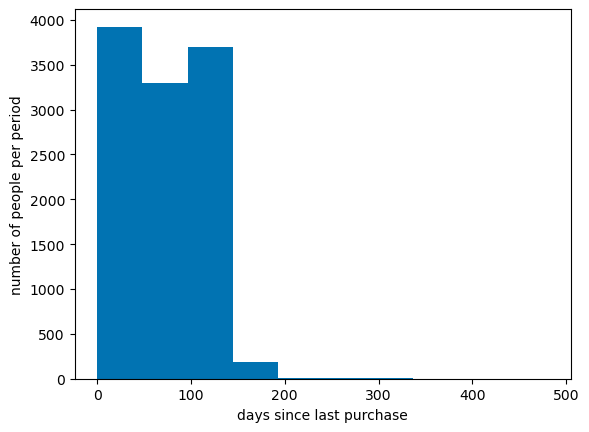

In [59]:
recencydist=list(recency["Recency"])
plt.hist(x=recencydist)
plt.xlabel('days since last purchase')
plt.ylabel('number of people per period')
sns.histplot()

<p style="font-size: 16px" font-family="sans-serif">
One can also see what is the payment installments distribution; the majority of customers has only 1 installment and a few people have made multiple installments.

<AxesSubplot:xlabel='payment_installments', ylabel='Count'>

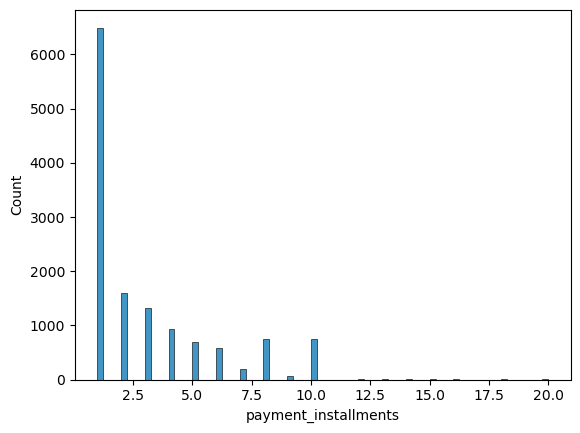

In [60]:

sns.histplot(data=df["payment_installments"])

<p style="font-size: 16px" font-family="sans-serif">
Of course something that may be of interest is the distribution of the payment types and therefore see how people purchase products.

<AxesSubplot:xlabel='payment_type', ylabel='count'>

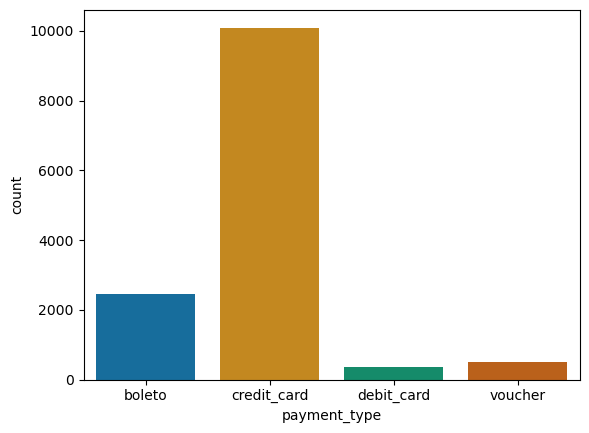

In [61]:
sns.countplot(x=df["payment_type"])

<p style="font-size: 16px" font-family="sans-serif">
Let us now see the top 15 product categories that customers have purchased

c:\Users\39339\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[Text(0, 0, 'bed_bath_table'),
 Text(1, 0, 'health_beauty'),
 Text(2, 0, 'housewares'),
 Text(3, 0, 'watches_gifts'),
 Text(4, 0, 'sports_leisure'),
 Text(5, 0, 'computers_accessories'),
 Text(6, 0, 'furniture_decor'),
 Text(7, 0, 'auto'),
 Text(8, 0, 'telephony'),
 Text(9, 0, 'garden_tools'),
 Text(10, 0, 'baby'),
 Text(11, 0, 'perfumery'),
 Text(12, 0, 'electronics'),
 Text(13, 0, 'toys'),
 Text(14, 0, 'pet_shop')]

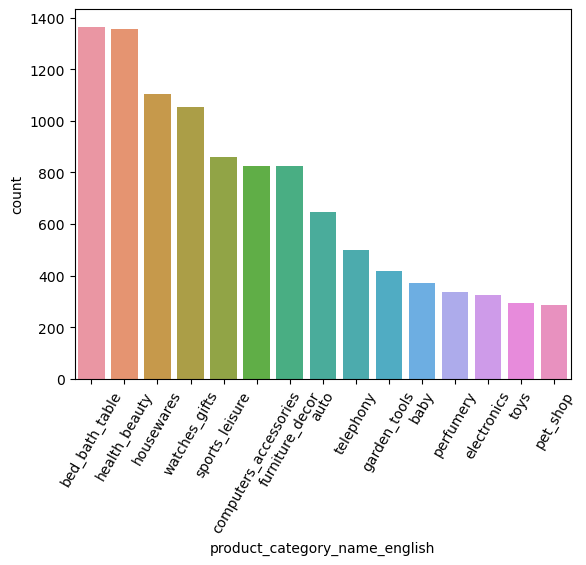

In [62]:
dfcat = pd.value_counts(df['product_category_name_english']).iloc[:15].index 

ax = sns.countplot(df['product_category_name_english'], order= dfcat)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)

Text(0.5, 1.0, 'Average Spending Distribution by Payment Type')

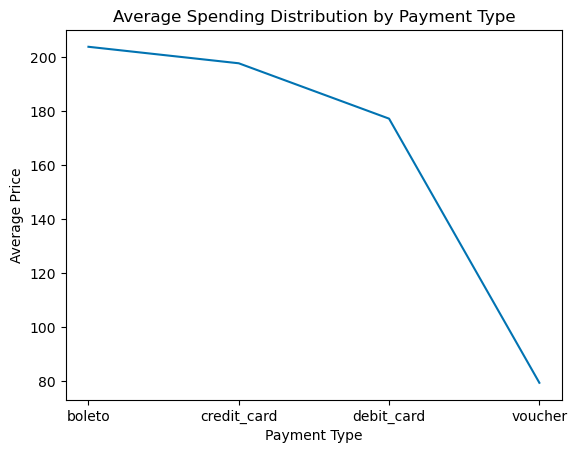

In [63]:
paymentdistr = df.groupby(['payment_type'])['payment_value'].mean().reset_index(name='Avg_Spending').sort_values(['Avg_Spending'], ascending = False)
x=["boleto","credit_card","debit_card","voucher"]
y=paymentdistr["Avg_Spending"]
plt.plot(x,y)
plt.xlabel("Payment Type")
plt.ylabel("Average Price")
plt.title("Average Spending Distribution by Payment Type")

<i style ="font-size: 15px">
As we can see, people who have done an order with the voucher tend to spend less due to the promotions(likely not a sure thing). Instead people who use a boleto spend much more. There isn't much difference between the credit card spending and the debit card while they spend a little bit less then users who use a boleto. This could be because there might be a promotion for those who use a credit or debit card. As we have seen before, the credit card is used much more then any other method.

One can also be interested in where the customers come from. We will regroup the first 15 states and also see their average spending per customer!

In [131]:
dfgeo = pd.value_counts(df['customer_state']).iloc[:20]

[Text(-2.5, 0, ''),
 Text(0.0, 0, 'SP'),
 Text(2.5, 0, ''),
 Text(5.0, 0, 'BA'),
 Text(7.5, 0, ''),
 Text(10.0, 0, 'PE'),
 Text(12.5, 0, ''),
 Text(15.0, 0, 'PB'),
 Text(17.5, 0, ''),
 Text(20.0, 0, '')]

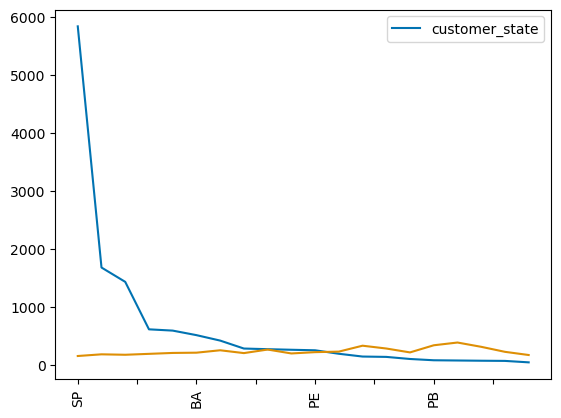

In [170]:
dfticks = pd.value_counts(df['customer_state']).iloc[:20].index.to_list() 
#fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

dfgeo.plot()


l = []
for i in range(20):
    l.append(df[df["customer_state"] == dfticks[i]]["payment_value"].mean())

ax = sns.lineplot(x = dfticks, y = l)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

#ax.set_xticklabels(dfticks, rotation = 60)
#ax.set_title("average spending in the state") '''

<i style ="font-size: 15px">
This is a representation of the top 5 states. One can see where people have spent most on average. In blue the number of people buying in that state and in orange the average money spent.

## Two alternatives: PCA and Autoencoders

<p style="font-size: 16px" font-family="sans-serif">
After finding out intersting features in the dataset, we are eager to clear things out, as previous results may be improved. 
Since the dataset is quite large, we want to use Principal component analysis to try to detect the most important features and preprocess the data 
using other features rather than only RFM attributes. There are some features that may be of particular interest, in particular:
    <ul>
<li> the payment type and number of installments are an important indicator, as we have seen the total spenditure varies a lot depending on them. </li>
<li> the customer state, that is, if a customer comes from a rich or poor area (demographics is important) </li>
<li> the product category, which may underpin some insights. </li>

In [64]:
from sklearn.compose import make_column_transformer
# one hot encoding for these features
transformer = make_column_transformer(
    (OneHotEncoder(sparse= False), ['payment_type', 'customer_city', 'product_category_name_english', 'payment_installments']),
     remainder='passthrough') 
encoded_df = transformer.fit_transform(df.loc(axis=1)['payment_type', 'customer_city', 'product_category_name_english','payment_installments'])


In [65]:
encoded_df = pd.DataFrame(encoded_df,columns=transformer.get_feature_names_out())
encoded_df.head()

,onehotencoder__payment_type_boleto,onehotencoder__payment_type_credit_card,onehotencoder__payment_type_debit_card,onehotencoder__payment_type_voucher,onehotencoder__customer_city_abaete,onehotencoder__customer_city_abaetetuba,onehotencoder__customer_city_abreu e lima,onehotencoder__customer_city_acaiaca,onehotencoder__customer_city_acailandia,onehotencoder__customer_city_acarau,...,onehotencoder__payment_installments_10,onehotencoder__payment_installments_11,onehotencoder__payment_installments_12,onehotencoder__payment_installments_13,onehotencoder__payment_installments_14,onehotencoder__payment_installments_15,onehotencoder__payment_installments_16,onehotencoder__payment_installments_17,onehotencoder__payment_installments_18,onehotencoder__payment_installments_20
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We then create the dataframe with all the features we want to include in our analysis.

In [66]:
f = ['Monetary value','Recency','Frequency']
newdf = pd.concat([rfm_dataset[f], encoded_df], axis=1)
newdf.head()

,Monetary value,Recency,Frequency,onehotencoder__payment_type_boleto,onehotencoder__payment_type_credit_card,onehotencoder__payment_type_debit_card,onehotencoder__payment_type_voucher,onehotencoder__customer_city_abaete,onehotencoder__customer_city_abaetetuba,onehotencoder__customer_city_abreu e lima,...,onehotencoder__payment_installments_10,onehotencoder__payment_installments_11,onehotencoder__payment_installments_12,onehotencoder__payment_installments_13,onehotencoder__payment_installments_14,onehotencoder__payment_installments_15,onehotencoder__payment_installments_16,onehotencoder__payment_installments_17,onehotencoder__payment_installments_18,onehotencoder__payment_installments_20
0,65.20,91.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,92.60,113.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,132.19,78.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,56.87,58.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42.86,23.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PCA, the principal component analysis

<p style="font-size: 16px" font-family="sans-serif">
As our dataset starts becoming quite large as the number of features has grown after introducing new features, we would like to extract as relevant information as possible by reducing data dmesionality, that is, creating "smaller" components which will be able to describe the dataset with less data. In the Quantitative models for data science course we have been introduced to a powerful technique, the so called "PCA" which is able, with few components (usually 2) to capture most of the variability of the dataset (relevant information). The first thing to do is to check the actual number of components to describe well the dataset without trading off too much information.

In [67]:

#getting started with PCA 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
#scaling the data is useful when dealing with PCA.
sc_features = newdf.copy()
sc = StandardScaler()
new = sc.fit_transform(sc_features['Monetary value'].array.reshape(-1,1))
new2 = sc.fit_transform(sc_features['Recency'].array.reshape(-1,1))
new3 = sc.fit_transform(sc_features['Frequency'].array.reshape(-1,1))
sc_features['Monetary value'] = new
sc_features['Recency'] = new2 
sc_features['Frequency'] = new3
sc_features.head() 


,Monetary value,Recency,Frequency,onehotencoder__payment_type_boleto,onehotencoder__payment_type_credit_card,onehotencoder__payment_type_debit_card,onehotencoder__payment_type_voucher,onehotencoder__customer_city_abaete,onehotencoder__customer_city_abaetetuba,onehotencoder__customer_city_abreu e lima,...,onehotencoder__payment_installments_10,onehotencoder__payment_installments_11,onehotencoder__payment_installments_12,onehotencoder__payment_installments_13,onehotencoder__payment_installments_14,onehotencoder__payment_installments_15,onehotencoder__payment_installments_16,onehotencoder__payment_installments_17,onehotencoder__payment_installments_18,onehotencoder__payment_installments_20
0,-0.282641,0.430215,2.792440,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.236679,0.947303,-0.319843,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.170269,0.124664,-0.319843,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.296614,-0.345416,-0.319843,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.320115,-1.168054,-0.319843,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
sc_features.dropna(inplace = True)   #dropping the nulls!
sc_features.shape

(11127, 1807)

<p style="font-size: 16px" font-family="sans-serif">
 What we do now, is to plot the cumulative plot of the principal components, that let us understand how much information(variability) n components provide together.

([<matplotlib.axis.XTick at 0x29e1cb70c10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

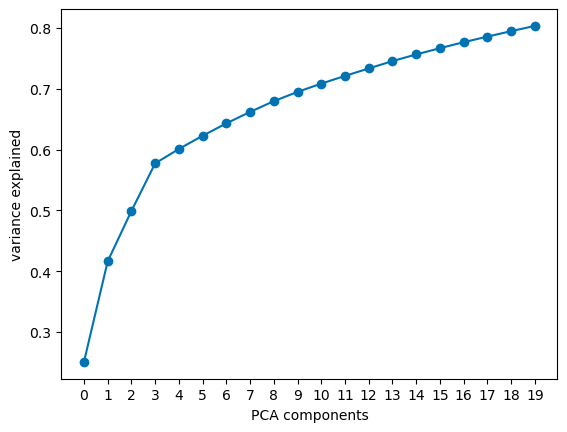

In [69]:
X_ = sc_features.values #scaled
#assessing how many components are needed

pca = PCA(n_components = 20)  #arbitrary
principalComponents = pca.fit_transform(X_)

#plotting the results
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_ratio_.cumsum(), marker ="o")   #pca.explained_ratio, displays howmuch information each
plt.xlabel('PCA components')                                        #each component holds in percentage
plt.ylabel('variance explained')
plt.xticks(features)


<i style ="font-size: 15px">
Usually, the accepted percentage of variability explained is 0.8, but in this case we suspect that more than 3 components would just contribute to explain "noise" and not real information needed for our analysis.

<p style="font-size: 16px" font-family="sans-serif">
Next, is to choose the number of clusters after that we decided to conìsider to components. We will again use the elbow method.

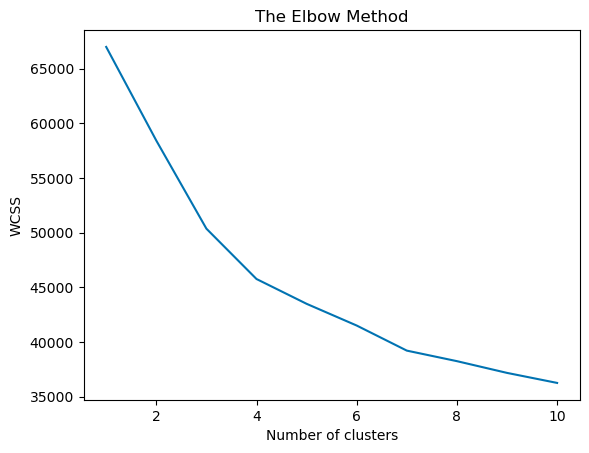

In [70]:
#getting started with PCA, reducing dimensionality of the original data
pca = PCA(n_components = 3)
scores = pca.fit_transform(X_)  #transforming the data

#applying kmeans, checking ideal number of clusters with elbow method

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<i style ="font-size: 15px">
The appropriate number of clusters appears to be 4 again, as 7 clusters are way more than necessary.

<p style="font-size: 16px" font-family="sans-serif">
We are now ready to tune this hyperparameter and visualize the results of the PCA which will be ablo to explain 60% of dataset variability using just 3 components! This is a nice and fast way to detect the most important features in the new dataset.

In [71]:

kmeanspca = KMeans(n_clusters = 4, init="k-means++", random_state = 42)
kmeanspca.fit(scores)


sc_features2 = sc_features.iloc[:,[0,1,2]]  #getting rid of encoded columns
#create the new dataframe, it will contain components and corresponding cluster labels detected.
segmkmeans = pd.concat([sc_features2, pd.DataFrame(scores)], axis=1)
#changing columns names 
segmkmeans.columns.values[-3:] = ['component1', 'component2', 'component3'] #changing columns name
segmkmeans['kmeansclusters'] = kmeanspca.labels_

In [72]:
segmkmeans.head()

,Monetary value,Recency,Frequency,component1,component2,component3,kmeansclusters
0,-0.282641,0.430215,2.792440,1.804680,0.286981,-1.526528,0
1,-0.236679,0.947303,-0.319843,-0.302487,0.974139,-0.166486,1
2,-0.170269,0.124664,-0.319843,-0.336909,0.168599,0.560583,1
3,-0.296614,-0.345416,-0.319843,-0.467217,-0.300705,-0.247501,2
4,-0.320115,-1.168054,-0.319843,-0.561030,-1.117913,-0.264737,2


<p style="font-size: 16px" font-family="sans-serif">
Now we can finally visualize the clusters made by kmeans after the PCA transformation. For the sake of clarity we will see data in 2D as it is easier to see what the differences are between clusters.

c:\Users\39339\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



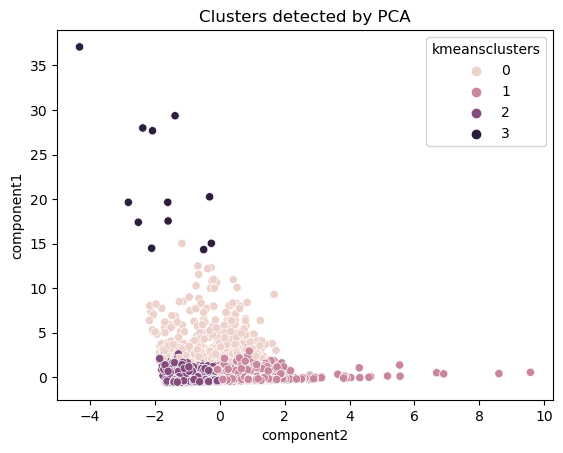

In [73]:
x = segmkmeans['component2']
y = segmkmeans['component1']
sns.scatterplot(x,y, hue = segmkmeans['kmeansclusters'])
plt.title("Clusters detected by PCA")
plt.show()

<i style ="font-size: 15px">
It is easy to see that the results we obtained are very similar to the ones before: There are few customers that are more distant (likely to be top spenders) and others who are less sparse (mid, at-risk customers and low spenders). To check that these clusters correspond to the ones before (roughly) we will check the properties of each cluster.

In [74]:
dfpca = rfmcopy.copy()
dfpca['kmeansclustersPCA'] =  kmeanspca.labels_   #adding clusters labels to the dataframe
dfpca.head()

,Customer ID,Recency,Monetary value,Frequency,kmeans_cluster,hc_clusters,sp_clusters,kmeansclustersPCA
0,001051abfcfdbed9f87b4266213a5df1,91,65.20,3,1,2,0,0
1,0013cd8e350a7cc76873441e431dd5ee,113,92.60,1,1,2,1,1
2,0015bc9fd2d5395446143e8b215d7c75,78,132.19,1,1,2,1,1
3,0018c09f333634ca9c80d9ff46e43e9c,58,56.87,1,1,2,0,2
4,001df1ee5c36767aa607001ab1a13a06,23,42.86,1,1,2,0,2


<p style="font-size: 16px" font-family="sans-serif">
After it, we want to check some clusters insights as we did before.

In [75]:
f2 = ['Recency','Monetary value','Frequency']
first = dfpca[dfpca['kmeansclustersPCA'] == 0][f2]
sec =  dfpca[dfpca['kmeansclustersPCA'] == 1][f2]
th = dfpca[dfpca['kmeansclustersPCA'] == 2][f2]
four = dfpca[dfpca['kmeansclustersPCA'] == 3][f2]

In [76]:
first.describe()

,Recency,Monetary value,Frequency
count,373.000000,373.000000,373.000000
mean,78.766756,1251.982172,3.664879
std,40.462538,1218.567077,1.243380
min,1.000000,12.910000,1.000000
25%,41.000000,473.490000,3.000000
50%,82.000000,877.280000,3.000000
75%,112.000000,1610.500000,4.000000
max,181.000000,6512.280000,12.000000


<i style ="font-size: 15px">
Even though some customers may not be correctly detected (minimum monetary value is 13 which is low), this cluster likely contains high-spenders, people who frequently purchase products in the business.

In [77]:
sec.describe()

,Recency,Monetary value,Frequency
count,5304.000000,5304.000000,5304.000000
mean,109.549208,192.196457,1.123303
std,23.646443,245.223456,0.328816
min,71.000000,14.380000,1.000000
25%,91.000000,68.130000,1.000000
50%,110.000000,119.655000,1.000000
75%,124.000000,206.030000,1.000000
max,481.000000,3209.720000,2.000000


<i style ="font-size: 15px">
In this cluster, there are present customers who are "at risk". Even though they have spent as much as the ones in the next cluster, their recency is much more far away as one can see both at the minimum and maximum(interquartile range)

In [78]:
th.describe()

,Recency,Monetary value,Frequency
count,5438.000000,5438.000000,5438.000000
mean,36.309489,176.874009,1.102979
std,19.803997,228.904775,0.304564
min,0.000000,10.710000,1.000000
25%,20.000000,62.910000,1.000000
50%,34.000000,112.045000,1.000000
75%,54.000000,193.447500,1.000000
max,73.000000,3184.340000,3.000000


<i style ="font-size: 15px">
It is interesting to compare this clusters to the previous one. This third cluster presents customers who can be labelled as "mid-spenders" as their frequency is on average the same, but their recency is much less, which means that they may be usual customers of the brazilian subsidiary.

In [79]:
four.describe()

,Recency,Monetary value,Frequency
count,12.000000,12.000000,12.000000
mean,84.083333,12673.595833,7.583333
std,38.483664,6926.670897,3.088346
min,32.000000,5948.360000,4.000000
25%,44.250000,8043.750000,6.000000
50%,86.500000,10124.475000,6.000000
75%,113.250000,16016.325000,10.250000
max,139.000000,29099.520000,13.000000


<i style ="font-size: 15px">
This fourth cluster presents again the top customers. This time, it seems that the algorithm has detected a relatively higher number of them.

In [80]:
customer_payment= df.groupby(by='customer_id',
                        as_index=False)['payment_type'].max()
                        
customer_installments= df.groupby(by='customer_id',
                        as_index=False)['payment_installments'].mean()
customer_city = df.groupby(by='customer_id',
                        as_index=False)['customer_state'].max()
product_category= df.groupby(by='customer_id',
                        as_index=False)['product_category_name_english'].max()

e = customer_payment.iloc[:, [1]]
e.reset_index(drop=True, inplace=True)
r = customer_installments.iloc[:,[1]]
r.reset_index(drop=True, inplace=True)
q = customer_city.iloc[:,[1]]
q.reset_index(drop=True, inplace=True)
t=product_category.iloc[:,[1]]
t.reset_index(drop=True, inplace=True)

temp = pd.concat([e,r,q,t], axis=1)

temp.head()
temp.reset_index(drop=True, inplace=True)
dfpcaf= pd.concat([dfpca, temp], axis=1)
dfpcaf.head()
                               

,Customer ID,Recency,Monetary value,Frequency,kmeans_cluster,hc_clusters,sp_clusters,kmeansclustersPCA,payment_type,payment_installments,customer_state,product_category_name_english
0,001051abfcfdbed9f87b4266213a5df1,91,65.20,3,1,2,0,0,voucher,1.0,SP,housewares
1,0013cd8e350a7cc76873441e431dd5ee,113,92.60,1,1,2,1,1,credit_card,9.0,SP,furniture_decor
2,0015bc9fd2d5395446143e8b215d7c75,78,132.19,1,1,2,1,1,credit_card,2.0,SP,fixed_telephony
3,0018c09f333634ca9c80d9ff46e43e9c,58,56.87,1,1,2,0,2,credit_card,5.0,SP,pet_shop
4,001df1ee5c36767aa607001ab1a13a06,23,42.86,1,1,2,0,2,credit_card,2.0,SP,food_drink


In [155]:
#addding silhouette score
silscores['kmeansPCA'] = silhouette_score(X_, kmeanspca.labels_ , metric='euclidean')

In [81]:
X_.shape

(11127, 1807)

## Autoencoder ANN

<p style="font-size: 16px" font-family="sans-serif">
Now we can finally visualize the clusters made by kmeans after the PCA transformation. For the sake of clarity we will see data in 2D as it is easier to see what the differences are between clusters.
We are now introducing a new concept in our analysis which is very important. As we tried with PCA, we want to reduce the most of dimensionality to capture the best datapoints which make clusters distinct (as we said, one should find something that maximizes the wcss that is the distance among clusters in Kmeans!). For this task, we use an autoencoder, an ANN which is able to reduce the dimensionality of the data. For a n large enough (in our case almost 2000) is it convienient to identify the features underpinning and correlating similar datapoints; in this way we can better represent the clusters. Let us see if this preprocessing step actually works!

<p style="font-size: 16px" font-family="sans-serif">
We will use the tensorflow package keras to feed and create the ANN; below the neural network is implemented, Autoencoder works as follows: </p>

- The autoencoder learns a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore insignificant data (“noise”).

- It has 2 main parts:  an encoder that maps the message (data) to a code, and a decoder that reconstructs the message (processed data) from the code, that is the decoder extracts the most relevant patterns and information we want to retrieve. Below an image showing its structure:

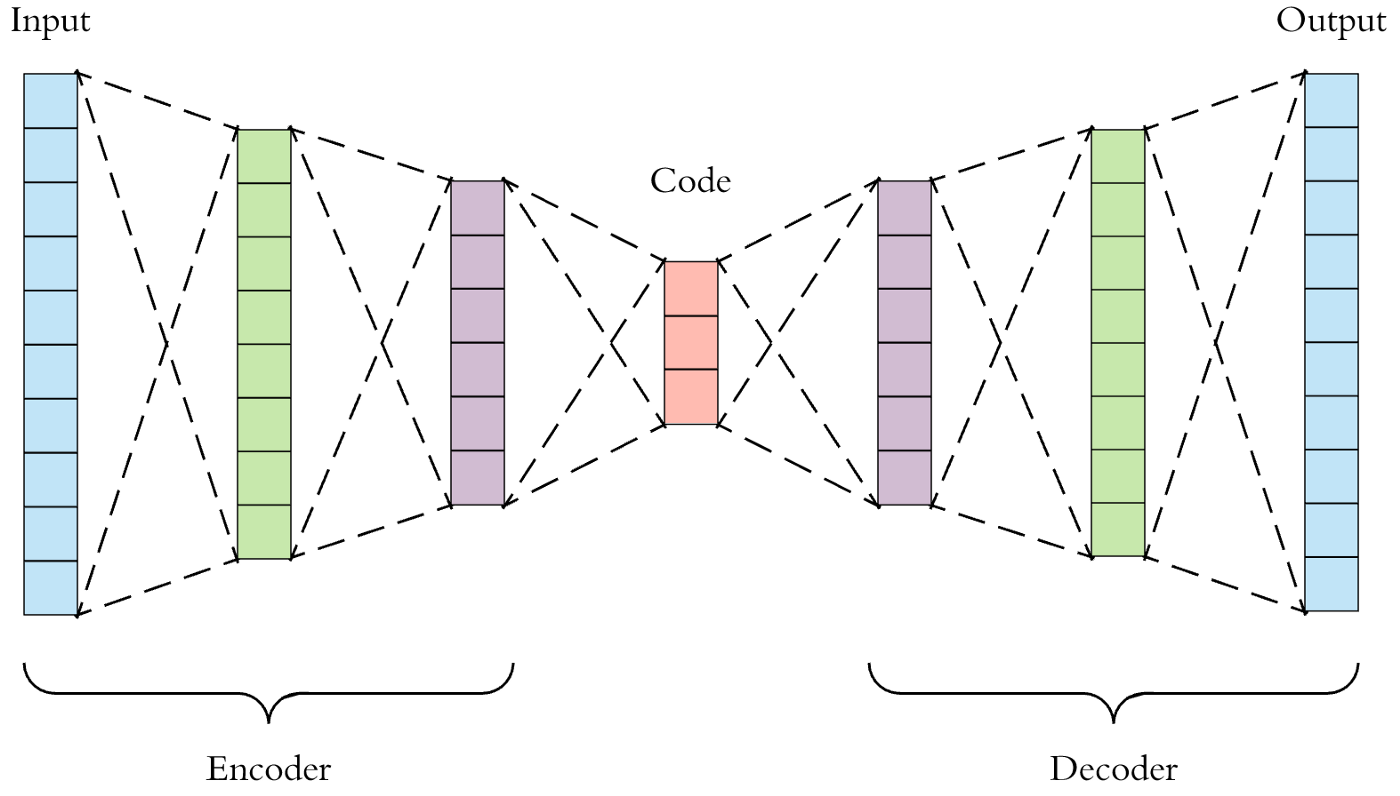

<p style="font-size: 16px" font-family="sans-serif">
The code below is an autoencoder artificial neural network made up of 4 encoders, the encoder layer, and 2 decoding layers that will output new reducted data!

In [82]:
import tensorflow as tf
import keras
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.optimizers import SGD 

encoding_dim = 7

# X_.shape is (11127, 1807) 

input_df = Input(shape=(1807,))   #let us define the input layer which will be the number of features in our df!


# Glorot normal initializer (Xavier normal initializer) draws samples from a truncated normal distribution 
#assembling the encoder!
x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)   #initializatiion of weights
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(x)

#encoding layer
encoded = Dense(10, activation='relu', kernel_initializer = 'glorot_uniform')(x)

#decoding layers
x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense(1807, kernel_initializer = 'glorot_uniform')(x)

# autoencoder layer
autoencoder = Model(input_df, decoded)

#encoder - used for our dimension reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')

#adam is a good optimizer and it works as the stochastic gradient descent and the mean_squared error is the cost function we decide to minimize.


<p style="font-size: 16px" font-family="sans-serif">
After compiling the autoencoder neural network, we are reay to fit the data.

In [83]:
#fitting the data
#batch size is set at 128 as it seems a standard in the industry we guess, verbose at 1, not much info needed

autoencoder.fit(X_,X_, batch_size = 128, epochs = 50, verbose= 1)

Epoch 1/50
87/87 [==============================] - 5s 43ms/step - loss: 0.0030
Epoch 2/50
87/87 [==============================] - 4s 47ms/step - loss: 0.0019
Epoch 3/50
87/87 [==============================] - 4s 44ms/step - loss: 0.0017
Epoch 4/50
87/87 [==============================] - 4s 45ms/step - loss: 0.0016
Epoch 5/50
87/87 [==============================] - 4s 44ms/step - loss: 0.0015
Epoch 6/50
87/87 [==============================] - 4s 44ms/step - loss: 0.0014
Epoch 7/50
87/87 [==============================] - 4s 43ms/step - loss: 0.0014
Epoch 8/50
87/87 [==============================] - 4s 44ms/step - loss: 0.0012
Epoch 9/50
87/87 [==============================] - 4s 43ms/step - loss: 0.0012
Epoch 10/50
87/87 [==============================] - 4s 43ms/step - loss: 0.0012
Epoch 11/50
87/87 [==============================] - 4s 44ms/step - loss: 0.0012
Epoch 12/50
87/87 [==============================] - 4s 44ms/step - loss: 0.0012
Epoch 13/50
87/87 [==================

<i style ="font-size: 15px">
After 50 epochs, the loss is extremely low, looks a good compromise! Below we encode the processed data after the fitting.

<p style="font-size: 16px" font-family="sans-serif">
Predicting (transorming) the data:

In [84]:
pr = encoder.predict(X_)

348/348 [==============================] - 4s 3ms/step


<p style="font-size: 16px" font-family="sans-serif">
As the data have been encoded and reduced in dimensionality, extracting useful patterns, again we will apply kmeans, the best algorithm tested so far according to silhouette score and also by clustering results using PCA.  <br>
After the encoding, we are now ready to implement kmeans and plot the resulting clusters! </p>

In [85]:
kmeansann = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42, algorithm = "lloyd")
y2_pr = kmeansann.fit_predict(pr)


In [86]:
#concatenating results to the dataframe and adding these clusters to the one containing all.
dfann = rfm_dataset.copy()
rfmcopy['clustersann'] = kmeansann.labels_
dfann['clustersann'] = kmeansann.labels_
dfann.head()

,Customer ID,Recency,Monetary value,Frequency,clustersann
0,001051abfcfdbed9f87b4266213a5df1,91,65.20,3,3
1,0013cd8e350a7cc76873441e431dd5ee,113,92.60,1,3
2,0015bc9fd2d5395446143e8b215d7c75,78,132.19,1,3
3,0018c09f333634ca9c80d9ff46e43e9c,58,56.87,1,1
4,001df1ee5c36767aa607001ab1a13a06,23,42.86,1,1


<p style="font-size: 16px" font-family="sans-serif">
We are ready to plot the clusters:

In [87]:
#plotting the results 
plot4 = go.Figure()

 
n4clusters = [0,1,2,3]   #same as we did before, the y_hc is a numpy array that returns, for each customer, the corresponding cluster assigned.
for x in n4clusters:
        plot4.add_trace(go.Scatter3d(x = dfann[dfann.clustersann == x]['Recency'], 
                                    y = dfann[dfann.clustersann == x]['Frequency'],
                                    z = dfann[dfann.clustersann == x]['Monetary value'],  
                                    mode='markers', marker_size = 8, marker_line_width = 1,
                                    name = 'Cluster ' + str(x+1)
                                    ))
                                                
                                            

            # changing the layout!

plot4.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'red'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'blue'),
                                zaxis=dict(title = 'Monetary value', titlefont_color = 'green')),
                font = dict(family = "Gilroy", color  = 'black', size = 12))

plot4.show()


<i style ="font-size: 15px">
The criteria taken into account seem to produce a much different result; The customers are now not only clustered because of RFM features but the ANN has influenced the clustering procedure. 

In [154]:
silscores['ann'] = silhouette_score(X_, kmeansann.labels_ , metric='euclidean')

<p style="font-size: 16px" font-family="sans-serif"> 
Let's see some clusters chaarcteristics:

In [88]:
dfann[dfann['clustersann'] == 0].describe()

,Recency,Monetary value,Frequency,clustersann
count,679.000000,679.000000,679.000000,679.0
mean,68.393225,475.229175,1.217968,0.0
std,41.586673,1892.460763,0.858534,0.0
min,0.000000,17.970000,1.000000,0.0
25%,32.000000,73.245000,1.000000,0.0
50%,65.000000,136.690000,1.000000,0.0
75%,106.000000,229.845000,1.000000,0.0
max,238.000000,29099.520000,12.000000,0.0


<i style ="font-size: 15px">
Top customers cluster.

<i style ="font-size: 15px">


In [89]:
dfann[dfann['clustersann'] == 1].describe()

,Recency,Monetary value,Frequency,clustersann
count,3185.000000,3185.000000,3185.000000,3185.0
mean,72.433281,208.417714,1.172998,1.0
std,43.176743,336.528979,0.589821,0.0
min,0.000000,13.890000,1.000000,1.0
25%,34.000000,66.060000,1.000000,1.0
50%,72.000000,118.610000,1.000000,1.0
75%,109.000000,205.990000,1.000000,1.0
max,481.000000,6142.320000,12.000000,1.0


<i style ="font-size: 15px">
mid-spenders

<i style ="font-size: 15px">

In [90]:
dfann[dfann['clustersann'] == 2].describe()

,Recency,Monetary value,Frequency,clustersann
count,2030.000000,2030.000000,2030.000000,2030.0
mean,70.362562,249.336379,1.131034,2.0
std,43.333811,533.303419,0.543407,0.0
min,1.000000,16.290000,1.000000,2.0
25%,31.000000,63.620000,1.000000,2.0
50%,67.000000,115.465000,1.000000,2.0
75%,109.000000,208.305000,1.000000,2.0
max,367.000000,8108.640000,13.000000,2.0


In [91]:
dfann[dfann['clustersann'] == 3].describe()

,Recency,Monetary value,Frequency,clustersann
count,5233.000000,5233.000000,5233.000000,5233.0
mean,74.319511,211.671984,1.252628,3.0
std,41.900730,322.410492,0.671906,0.0
min,0.000000,10.710000,1.000000,3.0
25%,36.000000,66.910000,1.000000,3.0
50%,76.000000,119.190000,1.000000,3.0
75%,111.000000,215.550000,1.000000,3.0
max,313.000000,5948.360000,11.000000,3.0


Customers who bought slightly more.

<i style ="font-size: 15px">

<i style ="font-size: 15px">
In the clustering made by kmeans after the autoencoding, Kmeans has given no importance on the rfm features but rather, it gives much more importance on the other features we introduced (payment and geographic information) as it is shown that each of the 4 customer segmentation present the same characteristics.

In [92]:
dfpcaf["clustersann"]=dfann["clustersann"]
dfpcaf.head()

,Customer ID,Recency,Monetary value,Frequency,kmeans_cluster,hc_clusters,sp_clusters,kmeansclustersPCA,payment_type,payment_installments,customer_state,product_category_name_english,clustersann
0,001051abfcfdbed9f87b4266213a5df1,91,65.20,3,1,2,0,0,voucher,1.0,SP,housewares,3
1,0013cd8e350a7cc76873441e431dd5ee,113,92.60,1,1,2,1,1,credit_card,9.0,SP,furniture_decor,3
2,0015bc9fd2d5395446143e8b215d7c75,78,132.19,1,1,2,1,1,credit_card,2.0,SP,fixed_telephony,3
3,0018c09f333634ca9c80d9ff46e43e9c,58,56.87,1,1,2,0,2,credit_card,5.0,SP,pet_shop,1
4,001df1ee5c36767aa607001ab1a13a06,23,42.86,1,1,2,0,2,credit_card,2.0,SP,food_drink,1


<p style="font-size: 16px" font-family="sans-serif">
Let us also see some insights of customers belonging to each cluster, below plots show the payment type, the most popular state where customer belong to and top product categories bought.

In [93]:
insights=["payment_type","payment_installments", "customer_state","product_category_name_english"]

c:\Users\39339\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



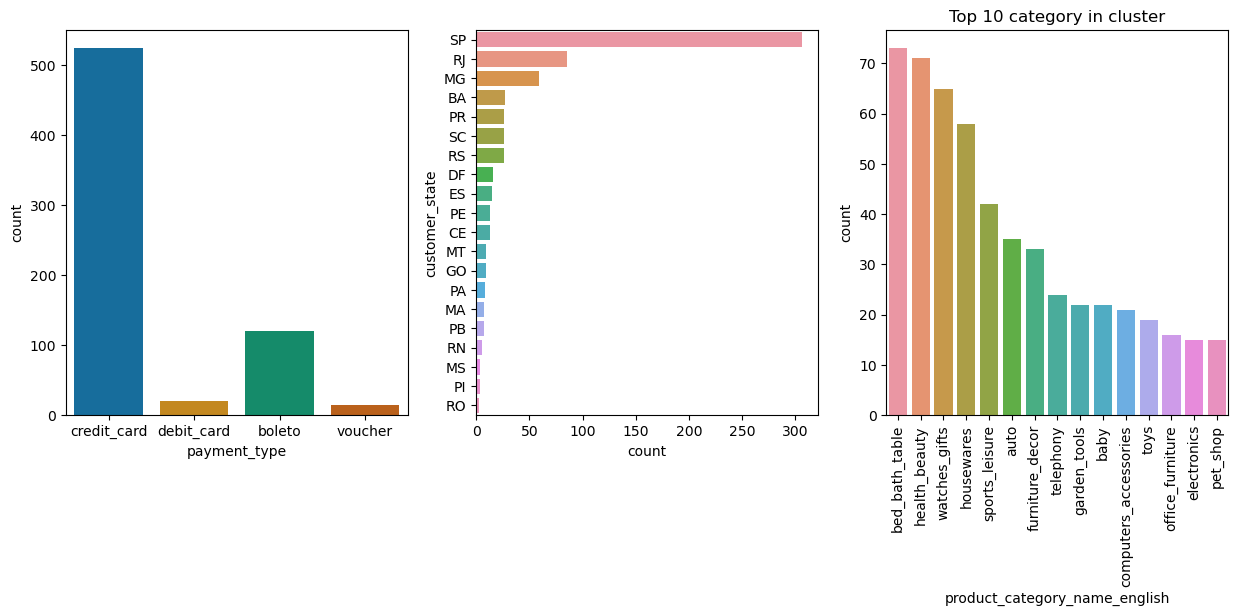

In [123]:
ins1=dfpcaf[dfpcaf["clustersann"]==0][insights]
#dins1={"payment_type":[],"payment_installments":[], "customer_state":[], "product_category_name_english":[]}
fig, (ax1,ax2,ax3)= plt.subplots(1,3, figsize=(15,5))



sns.countplot(x= ins1["payment_type"], ax= ax1)
#axs.set_title(title="Most used payment methods")



ord1 = pd.value_counts(ins1['customer_state']).iloc[:20].index
sns.countplot(y = ins1["customer_state"], order = ord1, ax= ax2)
#axs.set_title(title="Customers' states")




ord2 = pd.value_counts(ins1['product_category_name_english']).iloc[:15].index 
axs = sns.countplot(ins1['product_category_name_english'], order= ord2, ax = ax3)
axs.set_xticklabels(axs.get_xticklabels(), rotation = 90)
axs.set_title(label="Top 10 category in cluster")


plt.show()


<i style ="font-size: 15px">
Top customers insights.

c:\Users\39339\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



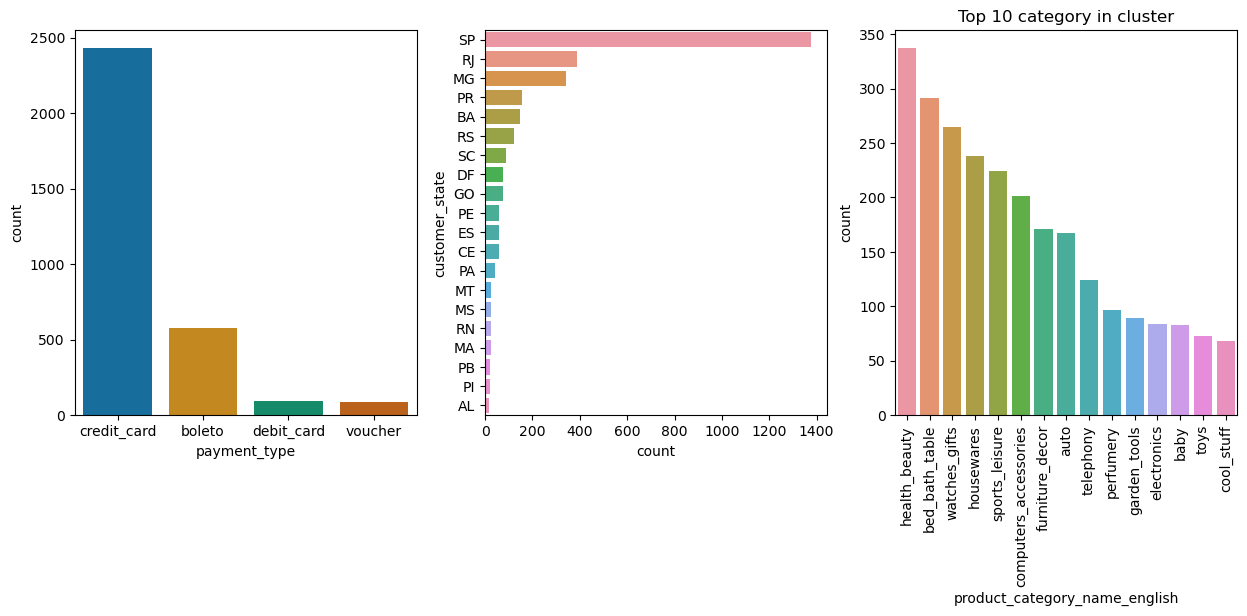

In [129]:
ins2=dfpcaf[dfpcaf["clustersann"]==1][insights]
fig, (ax1,ax2,ax3)= plt.subplots(1,3, figsize=(15,5))



sns.countplot(x= ins2["payment_type"], ax= ax1)
#axs.set_title(title="Most used payment methods")



ord1 = pd.value_counts(ins2['customer_state']).iloc[:20].index
sns.countplot(y = ins2["customer_state"], order = ord1, ax= ax2)
#axs.set_title(title="Customers' states")




ord2 = pd.value_counts(ins2['product_category_name_english']).iloc[:15].index 
axs = sns.countplot(ins2['product_category_name_english'], order= ord2, ax = ax3)
axs.set_xticklabels(axs.get_xticklabels(), rotation = 90)
axs.set_title(label="Top 10 category in cluster")


plt.show()

c:\Users\39339\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



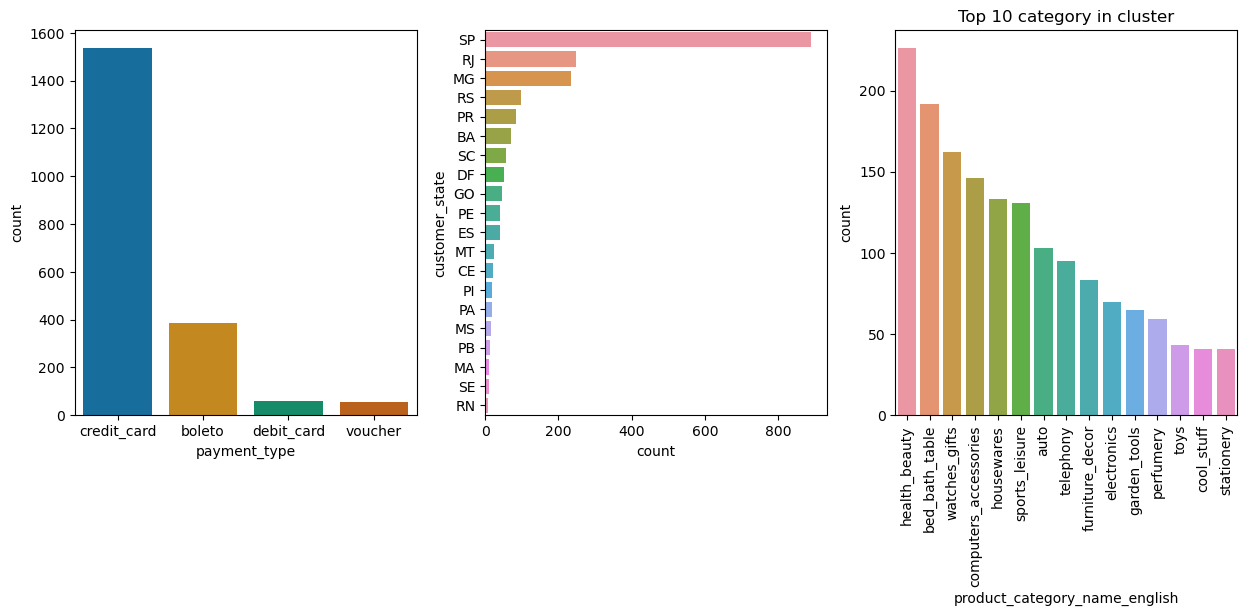

In [128]:
ins3=dfpcaf[dfpcaf["clustersann"]==2][insights]

fig, (ax1,ax2,ax3)= plt.subplots(1,3, figsize=(15,5))



sns.countplot(x= ins3["payment_type"], ax= ax1)
#axs.set_title(title="Most used payment methods")



ord1 = pd.value_counts(ins3['customer_state']).iloc[:20].index
sns.countplot(y = ins3["customer_state"], order = ord1, ax= ax2)
#axs.set_title(title="Customers' states")




ord2 = pd.value_counts(ins3['product_category_name_english']).iloc[:15].index 
axs = sns.countplot(ins3['product_category_name_english'], order= ord2, ax = ax3)
axs.set_xticklabels(axs.get_xticklabels(), rotation = 90)
axs.set_title(label="Top 10 category in cluster")


plt.show()

c:\Users\39339\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



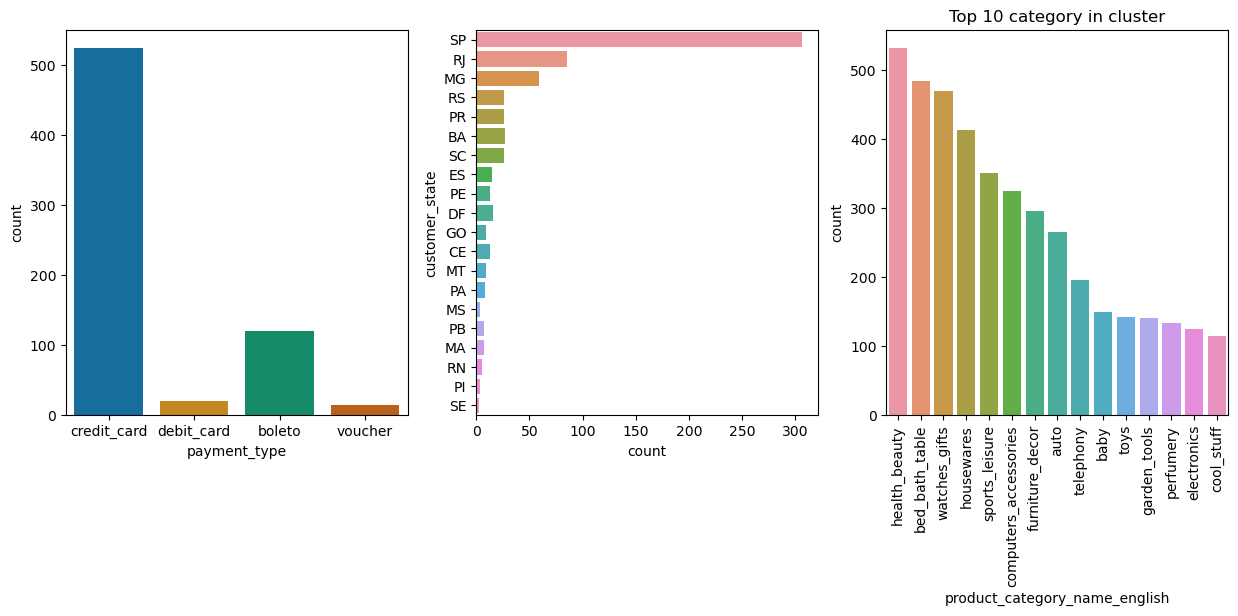

In [126]:
ins4=dfpcaf[dfpcaf["clustersann"]==3][insights]

fig, (ax1,ax2,ax3)= plt.subplots(1,3, figsize=(15,5))



sns.countplot(x= ins1["payment_type"], ax= ax1)
#axs.set_title(title="Most used payment methods")



ord1 = pd.value_counts(ins4['customer_state']).iloc[:20].index
sns.countplot(y = ins1["customer_state"], order = ord1, ax= ax2)
#axs.set_title(title="Customers' states")




ord2 = pd.value_counts(ins4['product_category_name_english']).iloc[:15].index 
axs = sns.countplot(ins4['product_category_name_english'], order= ord2, ax = ax3)
axs.set_xticklabels(axs.get_xticklabels(), rotation = 90)
axs.set_title(label="Top 10 category in cluster")


plt.show()

<i style ="font-size: 15px">
As we can see customers in these clusters behave almost the same; The majority has bought in SP(San Paolo) and many have used credit cards to buy.

## Final considerations

In our analysis we identified 4 main customer segmentations:
•	Low spenders/at-risk 
•	Mid Spenders
•	High spenders
•	Top customers

The way that the various algorithms segmented the data into these four clusters is described as follows:
1.	KMeans has detected majority of the customers into a single cluster, the low spenders and those who are likely to leave the business, while the high spenders and top customers are a minority.
2.	Hierarchical Cluster had a similar approach to KMeans, but with a key difference. Whilst the low and at-risk customers remain the same, the mid spenders cluster size has increased, while the high and top spenders are unchanged.
3.	Spectral Clustering has a more balanced partition, we don’t see very small segmentations like we did in KMeans and Hierarchical Cluster. We see a more even distribution of the customer segmentation; also standard deviations suggest that the datapoints (customers) in each cluster are way more similar to each other than before.
4.	For the Principal Component Analysis, we can see that more high spenders have been detected compared to KMeans and HC, but when compared to Spectral, the clusters' size is similar. An interesting difference is the differentiation between those who are at-risk compared to the mid spenders. In fact the PCA gave more importance to the recency compared to the other three algorithms and probably also considered the other factors, such as the payment method, installments and others we have stated before.
5.	Autoencoder ANN has provided very similar clusters. Not only does not it take into account the monetary value but also other features such as payment and demographics information do not seem to influence the segments.

Below, a dataframe showing the silhouette scores.

In [160]:
dfscores = pd.DataFrame(silscores, index = [0])
dfscores.head()

,kmeans,hierarchical clustering,Spectral clustering,ann,kmeansPCA
0,0.816001,0.79044,0.34288,0.021864,0.149147


Even though the silhouette score of the PCA kmeans is way less than the ones in rfm kmeans and hierarchical clustering, the algorithm has detected better segmentations; The standard deviations among datapoints is way lower, meaning that the customers belonging to each cluster are generally more similar to each other, while kmeans and hierarchical have identified top customers really well, but disregarded the importance of segmenting mid and at-risk/low spenders properly. 
The spectral clustering instead has done a great job as one can see both at the segmentations' descriptions and also at the silhouette score, which is way less than its 2 main competitors but still decent.

## Final takeaways 

After a thorough investigation, there are some takeaways that the Brazilian subsidiary can get:
- Brazilian customers are segmented in 4 categories, low spenders(people who buy occasionaly or just made one single purchase because of vouchers or promotions); at-risk customers, who buy with a slightly higher frequency but spend quite more than the latter; mid-spenders who are usual customers and finally top and high-spenders customers, those who buy frequently (more than 4 times) and spend immensely more than the average.

- The subsidiary should focus the email campaign on both low and at-risk customers to retain them, by proposing promotions and discounts to those returning/continuing to buy in the business.

- For midspenders, the firm should introduce new and less-bought products; As we have seen there are products who have been purchased way more than others; it can be useful to increase selling in those who are not purchased as much.

- For high and top spenders, the firm could as well promote the usual products they buy (as seen in the plots below they buy expensive products such as furnitures, computers exc...) but at the same time propose more general-user products to increase the already large Lifetimevalue they have.

In [163]:
dfpcaf.head()

,Customer ID,Recency,Monetary value,Frequency,kmeans_cluster,hc_clusters,sp_clusters,kmeansclustersPCA,payment_type,payment_installments,customer_state,product_category_name_english,clustersann
0,001051abfcfdbed9f87b4266213a5df1,91,65.20,3,1,2,0,0,voucher,1.0,SP,housewares,3
1,0013cd8e350a7cc76873441e431dd5ee,113,92.60,1,1,2,1,1,credit_card,9.0,SP,furniture_decor,3
2,0015bc9fd2d5395446143e8b215d7c75,78,132.19,1,1,2,1,1,credit_card,2.0,SP,fixed_telephony,3
3,0018c09f333634ca9c80d9ff46e43e9c,58,56.87,1,1,2,0,2,credit_card,5.0,SP,pet_shop,1
4,001df1ee5c36767aa607001ab1a13a06,23,42.86,1,1,2,0,2,credit_card,2.0,SP,food_drink,1


c:\Users\39339\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

c:\Users\39339\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



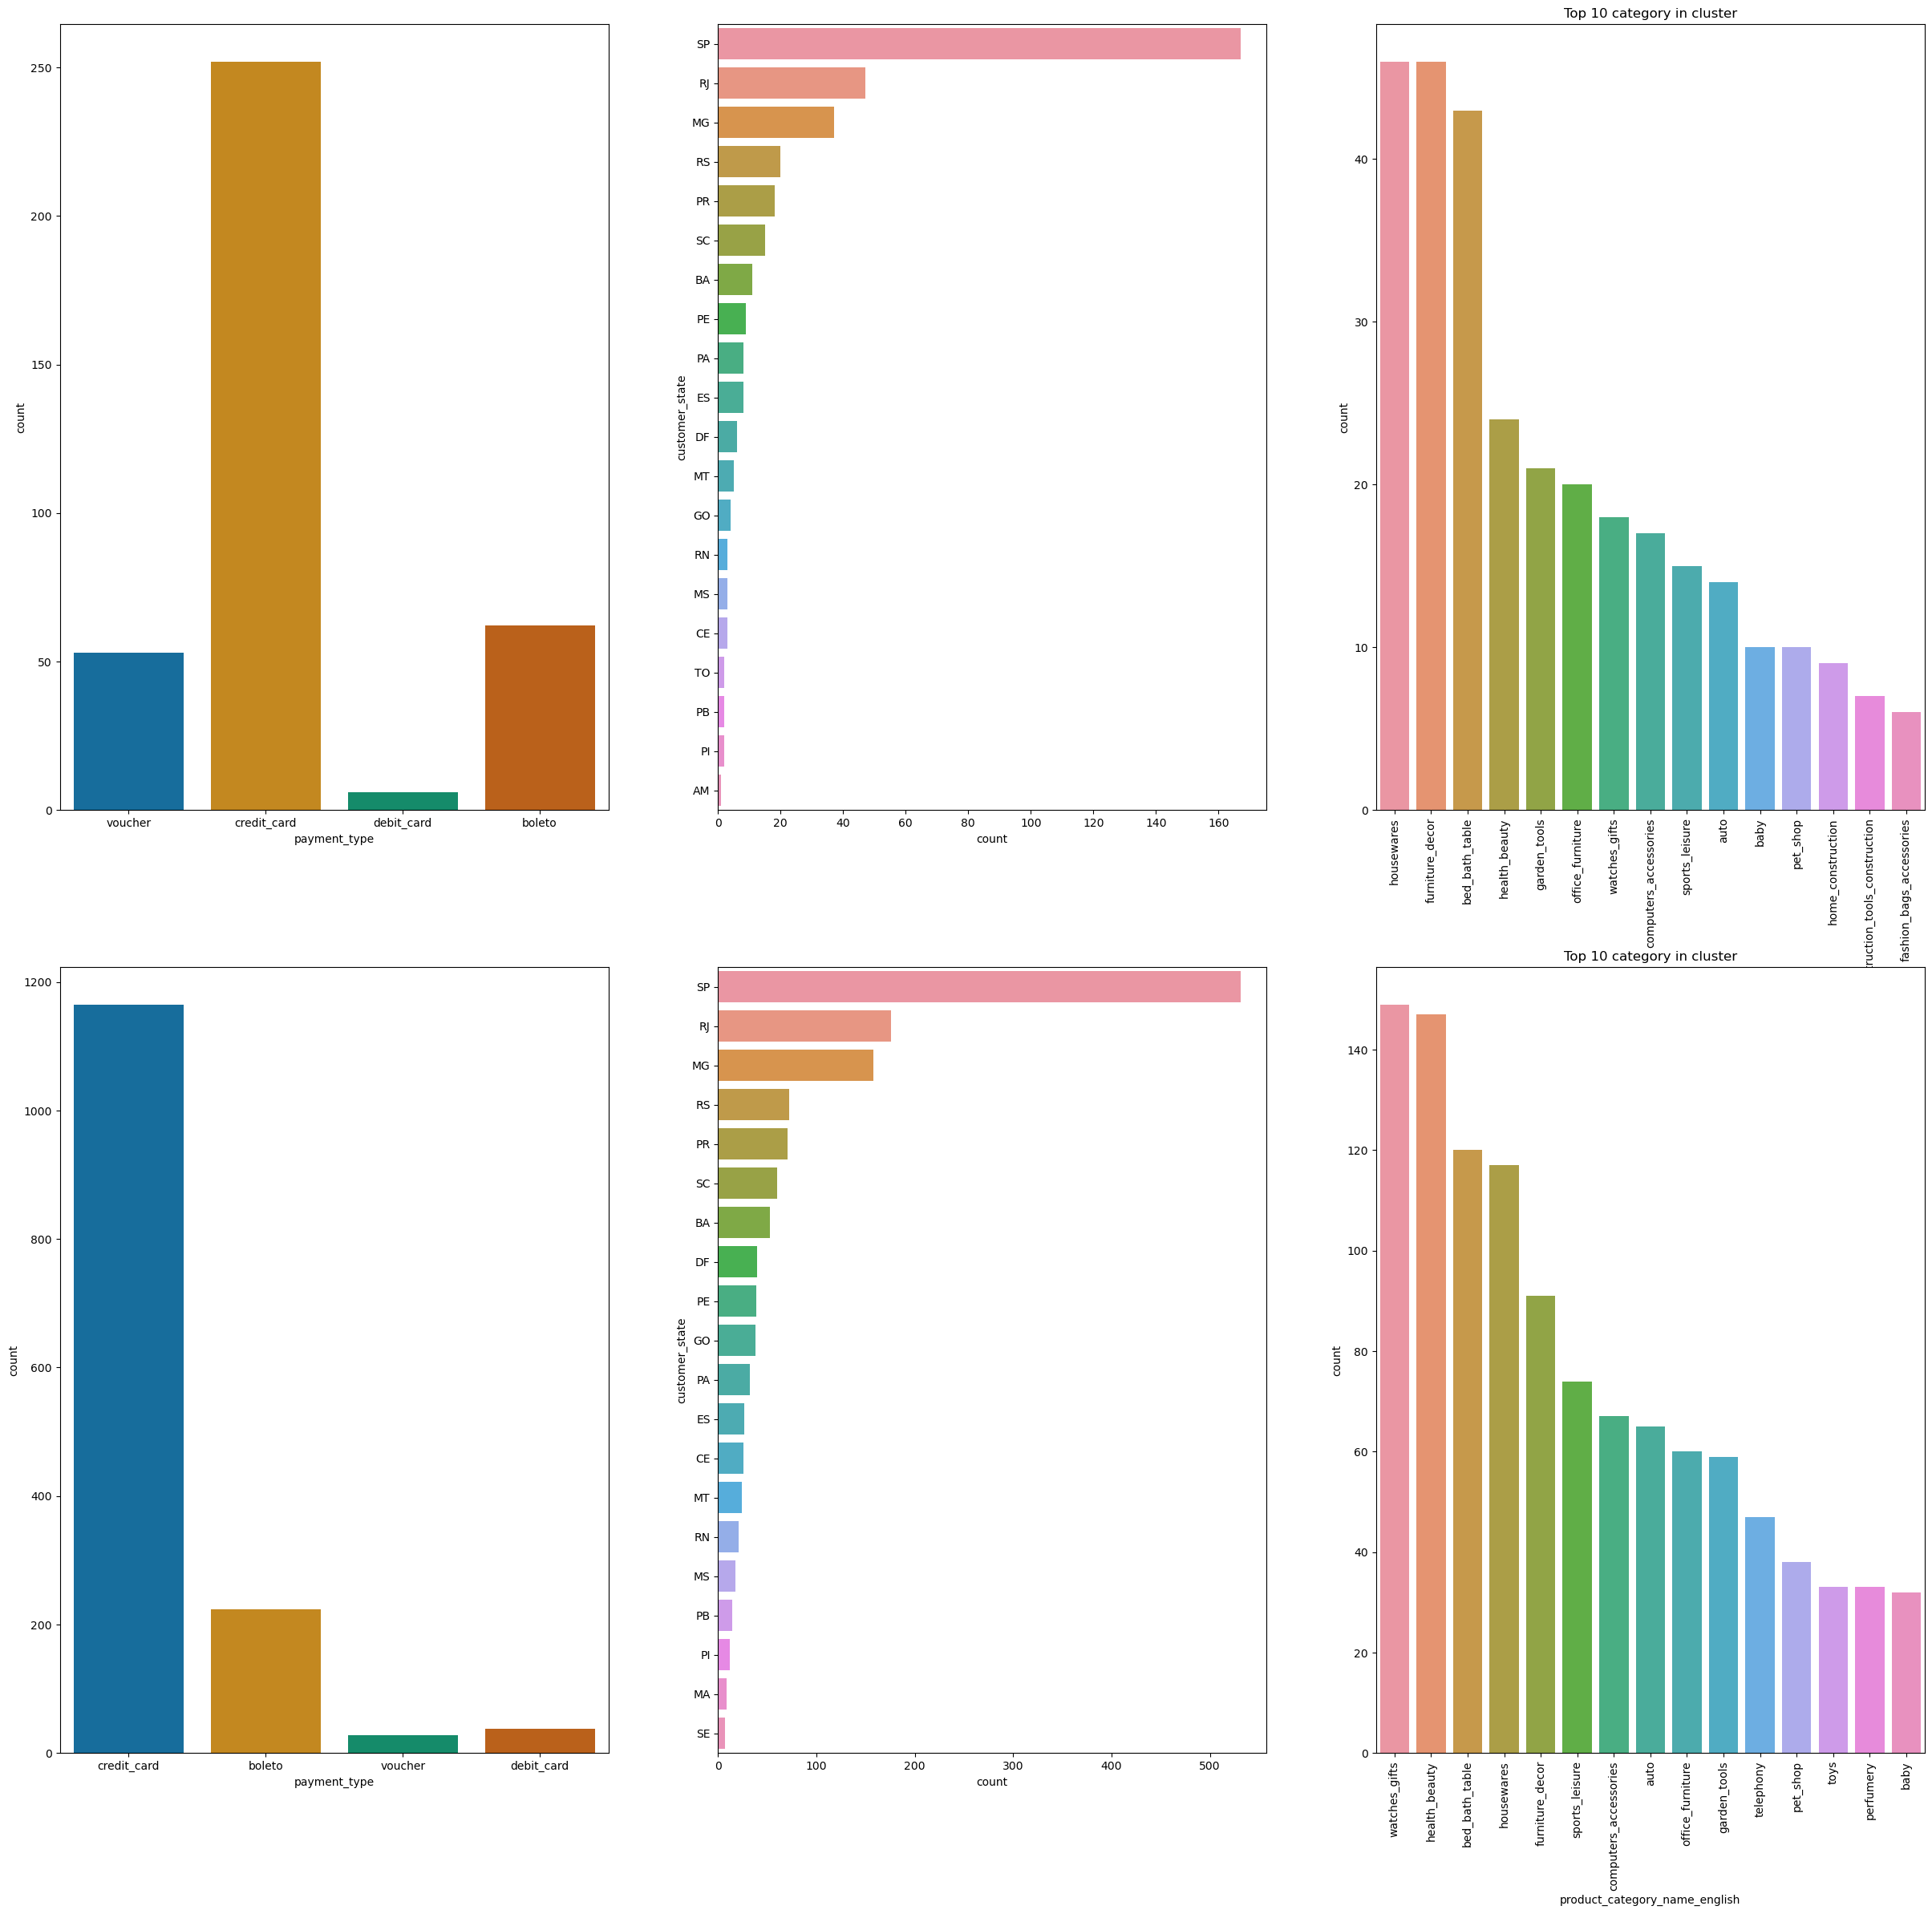

In [168]:
#high and top spenders identified in PCA and spectral
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6))= plt.subplots(2,3, figsize=(30,28))
ins5 = dfpcaf[(dfpcaf['kmeansclustersPCA'] == 0) | (dfpcaf['kmeansclustersPCA'] == 0)][insights]


sns.countplot(x= ins5["payment_type"], ax= ax1)
#axs.set_title(title="Most used payment methods")



ord1 = pd.value_counts(ins5['customer_state']).iloc[:20].index
sns.countplot(y = ins5["customer_state"], order = ord1, ax= ax2)
#axs.set_title(title="Customers' states")




ord2 = pd.value_counts(ins5['product_category_name_english']).iloc[:15].index 
axs = sns.countplot(ins5['product_category_name_english'], order= ord2, ax = ax3)
axs.set_xticklabels(axs.get_xticklabels(), rotation = 90)
axs.set_title(label="Top 10 category in cluster")


ins6 = dfpcaf[(dfpcaf['sp_clusters'] == 2 ) | (dfpcaf['sp_clusters'] == 3 )][insights]

sns.countplot(x= ins6["payment_type"], ax= ax4)
#axs.set_title(title="Most used payment methods")



ord1 = pd.value_counts(ins6['customer_state']).iloc[:20].index
sns.countplot(y = ins6["customer_state"], order = ord1, ax= ax5)
#axs.set_title(title="Customers' states")




ord2 = pd.value_counts(ins6['product_category_name_english']).iloc[:15].index 
axs = sns.countplot(ins6['product_category_name_english'], order= ord2, ax = ax6)
axs.set_xticklabels(axs.get_xticklabels(), rotation = 90)
axs.set_title(label="Top 10 category in cluster")


plt.show()

<i style ="font-size: 15px">
Respectively, on first row, high and top spenders insights identified by Pca and spectral clustering on second. 

Below, some insights about low and at risk customers:

c:\Users\39339\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

c:\Users\39339\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



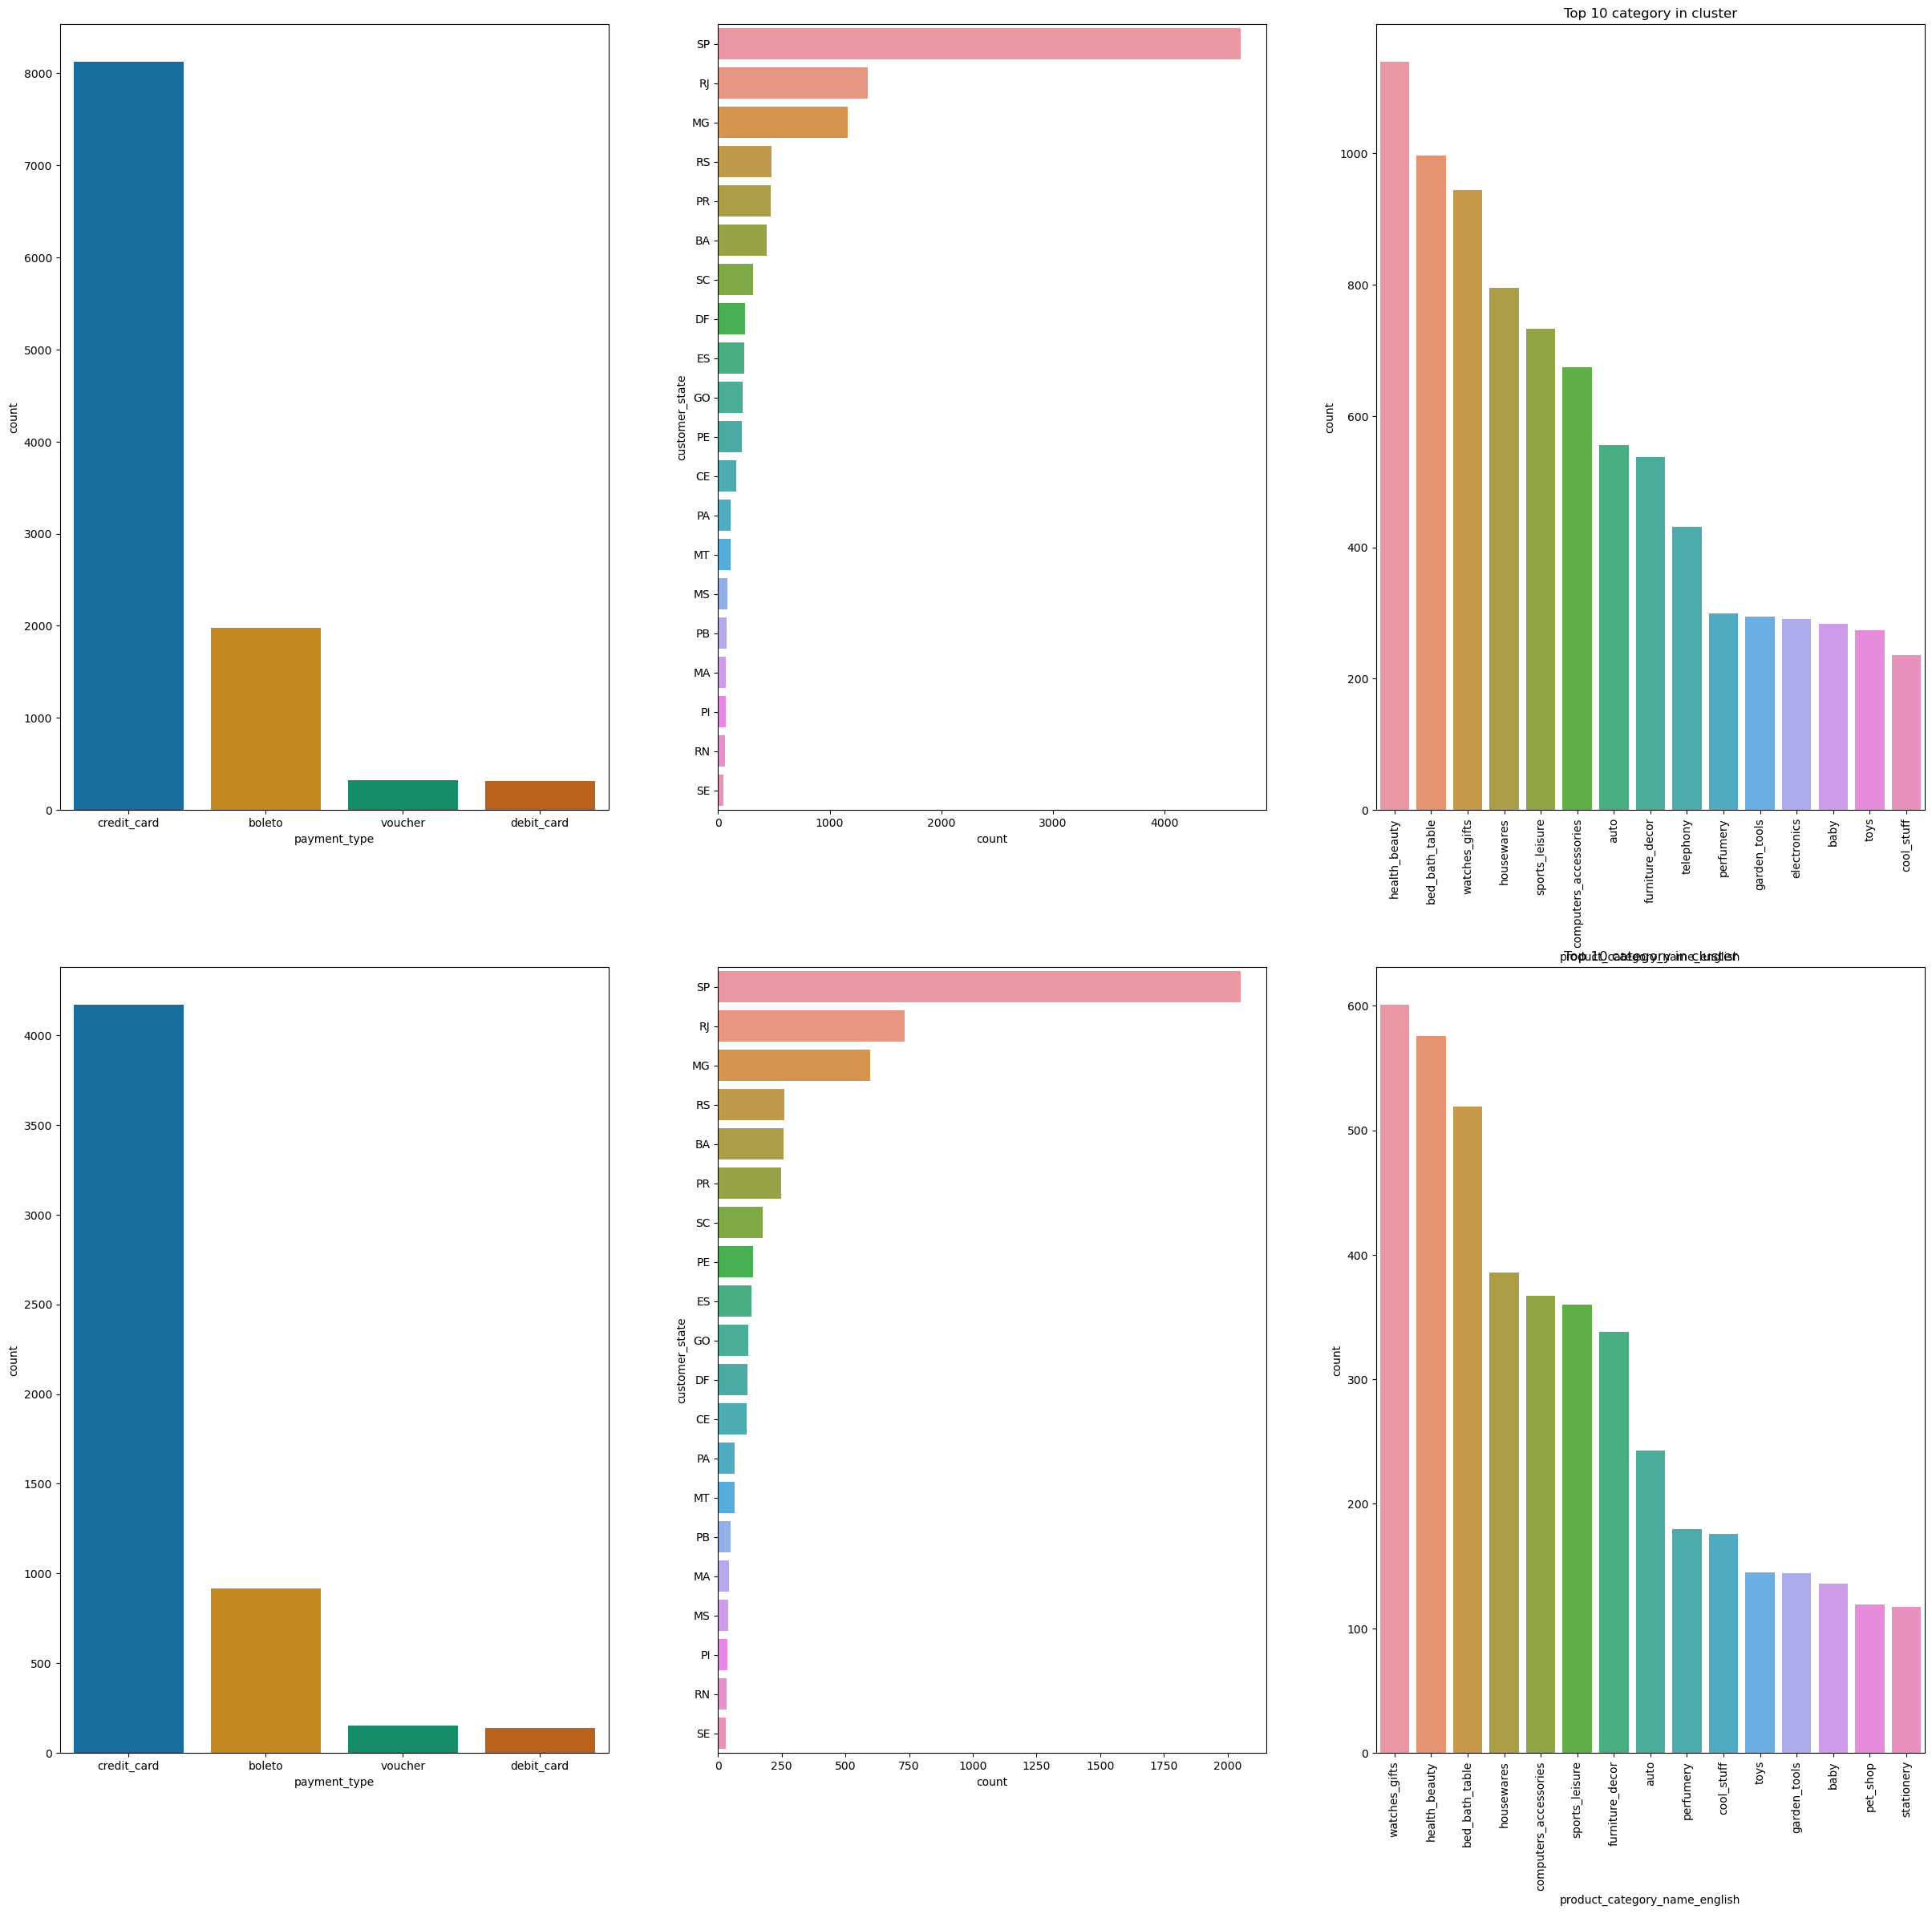

In [169]:
#high and top spenders identified in PCA and spectral
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6))= plt.subplots(2,3, figsize=(30,28))
ins7 = dfpcaf[(dfpcaf['kmeansclustersPCA'] == 1) | (dfpcaf['kmeansclustersPCA'] == 2)][insights]


sns.countplot(x= ins7["payment_type"], ax= ax1)
#axs.set_title(title="Most used payment methods")



ord1 = pd.value_counts(ins7['customer_state']).iloc[:20].index
sns.countplot(y = ins7["customer_state"], order = ord1, ax= ax2)
#axs.set_title(title="Customers' states")




ord2 = pd.value_counts(ins7['product_category_name_english']).iloc[:15].index 
axs = sns.countplot(ins7['product_category_name_english'], order= ord2, ax = ax3)
axs.set_xticklabels(axs.get_xticklabels(), rotation = 90)
axs.set_title(label="Top 10 category in cluster")


ins8 = dfpcaf[dfpcaf['sp_clusters'] == 1][insights]

sns.countplot(x= ins8["payment_type"], ax= ax4)
#axs.set_title(title="Most used payment methods")



ord1 = pd.value_counts(ins8['customer_state']).iloc[:20].index
sns.countplot(y = ins8["customer_state"], order = ord1, ax= ax5)
#axs.set_title(title="Customers' states")




ord2 = pd.value_counts(ins8['product_category_name_english']).iloc[:15].index 
axs = sns.countplot(ins8['product_category_name_english'], order= ord2, ax = ax6)
axs.set_xticklabels(axs.get_xticklabels(), rotation = 90)
axs.set_title(label="Top 10 category in cluster")


plt.show()

<i style ="font-size: 15px">
As we can see low and at-risk customers buy the same type of products (the top three are the same). Targeting emails offering discounts on these products may be a winning strategy to raise revenues and retain/regain these customers, with more who have bought just once and then left the business.